In [ ]:
#Loading Libraries and Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from transformers import pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np


In [ ]:
# Load the data into DataFrames
forex_data = pd.read_csv('/content/USD_RUB_Historical_Data.csv')
newsfeed_data = pd.read_csv('/content/USDRUB_NEWS.csv')


In [ ]:
# Display the first few rows of each DataFrame to confirm successful loading
print("Forex Data:")
print(forex_data.head())

print("\nNewsfeed Data:")
print(newsfeed_data.head())

Forex Data:
         Date    Price     Open     High      Low  Vol. Change %
0  06/16/2024  88.9896  88.9813  88.9921  88.9422   NaN   -0.66%
1  06/14/2024  89.5779  87.8755  90.2496  87.8529   NaN    1.94%
2  06/13/2024  87.8754  89.0214  91.7479  85.7496   NaN   -1.38%
3  06/11/2024  89.1025  88.5500  89.2890  88.5500   NaN    0.62%
4  06/10/2024  88.5500  89.3475  89.4350  88.5500   NaN   -0.89%

Newsfeed Data:
                                       Title/Heading  \
0  Russian banks' profits drop slightly m/m to $2...   
1       Russian stocks hit highest in over two years   
2  Russian banks' profits drop 22% m/m to $3 bill...   
3  Russian rouble hits one-week low vs dollar aft...   
4  Foreign firms' Russian 'exit tax' payments at ...   

                                        Post/Comment     Time/Date  
0  MOSCOW (Reuters) - Russian banks' profits fell...  Apr 19, 2024  
1  MOSCOW (Reuters) - Russia's benchmark stock in...  Apr 01, 2024  
2  MOSCOW (Reuters) - Russian banks' p

In [ ]:
# Data Cleaning
forex_data.drop_duplicates(inplace=True)
newsfeed_data.drop_duplicates(inplace=True)
newsfeed_data.dropna(inplace=True)

# Ensure the columns with numerical data are identified correctly before filling NaNs
numerical_cols = forex_data.select_dtypes(include=['float64', 'int64']).columns
forex_data[numerical_cols] = forex_data[numerical_cols].apply(lambda x: x.fillna(x.mean()))

print("Cleaned Forex Data:")
print(forex_data.head())

print("\nCleaned Newsfeed Data:")
print(newsfeed_data.head())


Cleaned Forex Data:
         Date    Price     Open     High      Low  Vol. Change %
0  06/16/2024  88.9896  88.9813  88.9921  88.9422   NaN   -0.66%
1  06/14/2024  89.5779  87.8755  90.2496  87.8529   NaN    1.94%
2  06/13/2024  87.8754  89.0214  91.7479  85.7496   NaN   -1.38%
3  06/11/2024  89.1025  88.5500  89.2890  88.5500   NaN    0.62%
4  06/10/2024  88.5500  89.3475  89.4350  88.5500   NaN   -0.89%

Cleaned Newsfeed Data:
                                       Title/Heading  \
0  Russian banks' profits drop slightly m/m to $2...   
1       Russian stocks hit highest in over two years   
2  Russian banks' profits drop 22% m/m to $3 bill...   
3  Russian rouble hits one-week low vs dollar aft...   
4  Foreign firms' Russian 'exit tax' payments at ...   

                                        Post/Comment     Time/Date  
0  MOSCOW (Reuters) - Russian banks' profits fell...  Apr 19, 2024  
1  MOSCOW (Reuters) - Russia's benchmark stock in...  Apr 01, 2024  
2  MOSCOW (Reuters) - 

In [ ]:
# Standardizing and renaming columns for forex_data
forex_data.rename(columns={
    'Date': 'timestamp',
    'Price': 'close',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Vol.': 'volume',
    'Change %': 'change_pct'
}, inplace=True)

# Standardizing and renaming columns for newsfeed_data
newsfeed_data.rename(columns={
    'Title/Heading': 'title',
    'Post/Comment': 'comment',
    'Time/Date': 'timestamp'
}, inplace=True)

# Remove percentage sign and convert to float
forex_data['change_pct'] = forex_data['change_pct'].str.replace('%', '').astype(float)
# Display the first few rows to confirm changes

print("Renamed Forex Data Columns:")
print(forex_data.head())

print("\nRenamed Newsfeed Data Columns:")
print(newsfeed_data.head())


Renamed Forex Data Columns:
    timestamp    close     open     high      low  volume  change_pct
0  06/16/2024  88.9896  88.9813  88.9921  88.9422     NaN       -0.66
1  06/14/2024  89.5779  87.8755  90.2496  87.8529     NaN        1.94
2  06/13/2024  87.8754  89.0214  91.7479  85.7496     NaN       -1.38
3  06/11/2024  89.1025  88.5500  89.2890  88.5500     NaN        0.62
4  06/10/2024  88.5500  89.3475  89.4350  88.5500     NaN       -0.89

Renamed Newsfeed Data Columns:
                                               title  \
0  Russian banks' profits drop slightly m/m to $2...   
1       Russian stocks hit highest in over two years   
2  Russian banks' profits drop 22% m/m to $3 bill...   
3  Russian rouble hits one-week low vs dollar aft...   
4  Foreign firms' Russian 'exit tax' payments at ...   

                                             comment     timestamp  
0  MOSCOW (Reuters) - Russian banks' profits fell...  Apr 19, 2024  
1  MOSCOW (Reuters) - Russia's benchmark stoc

In [ ]:
# Data Integration
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'])
newsfeed_data['timestamp'] = pd.to_datetime(newsfeed_data['timestamp'])
combined_data = pd.merge(forex_data, newsfeed_data, on='timestamp', how='inner')

In [ ]:
# Display the first few rows to confirm integration
print("Combined Data:")
print(combined_data.head())


Combined Data:
   timestamp    close     open     high      low  volume  change_pct  \
0 2024-04-19  93.1525  93.7800  94.0117  92.9257     NaN       -0.67   
1 2024-04-01  92.1425  92.4800  92.4800  92.1425     NaN       -0.36   
2 2024-03-26  92.7000  92.5800  92.8718  92.3600     NaN        0.13   
3 2024-03-25  92.5800  92.7950  93.0475  92.5157     NaN       -0.23   
4 2024-03-20  92.2500  92.6475  92.8547  92.1976     NaN       -0.43   

                                               title  \
0  Russian banks' profits drop slightly m/m to $2...   
1       Russian stocks hit highest in over two years   
2  Russian banks' profits drop 22% m/m to $3 bill...   
3  Russian rouble hits one-week low vs dollar aft...   
4  Foreign firms' Russian 'exit tax' payments at ...   

                                             comment  
0  MOSCOW (Reuters) - Russian banks' profits fell...  
1  MOSCOW (Reuters) - Russia's benchmark stock in...  
2  MOSCOW (Reuters) - Russian banks' profits fell.

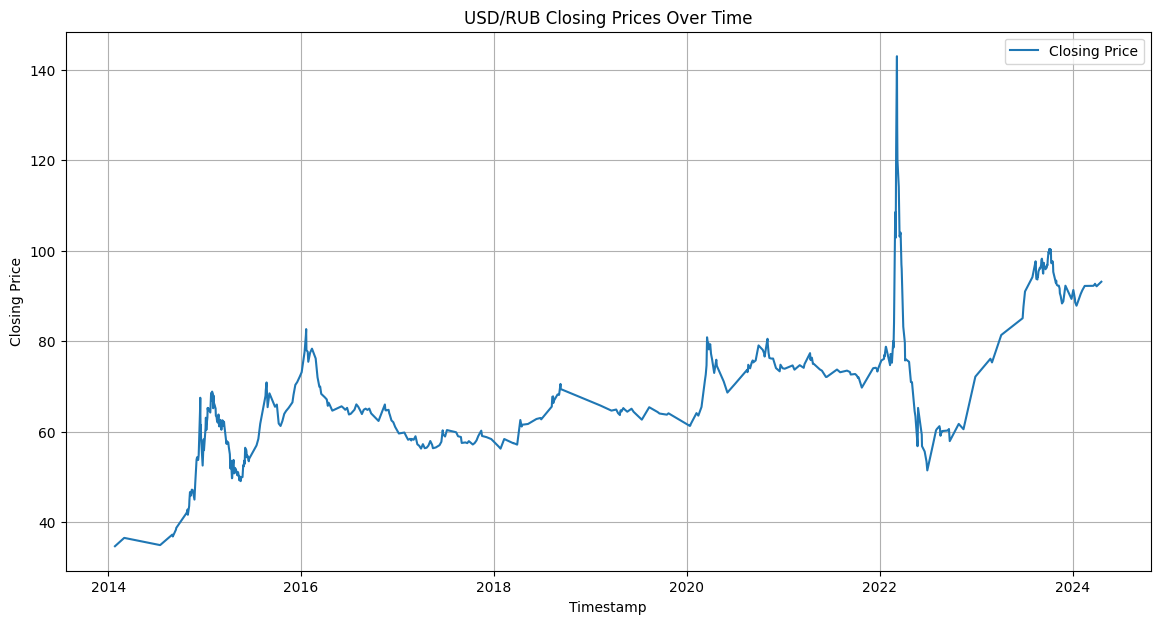

In [ ]:
# Time-series visualization of closing prices
plt.figure(figsize=(14, 7))
plt.plot(combined_data['timestamp'], combined_data['close'], label='Closing Price')
plt.xlabel('Timestamp')
plt.ylabel('Closing Price')
plt.title('USD/RUB Closing Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

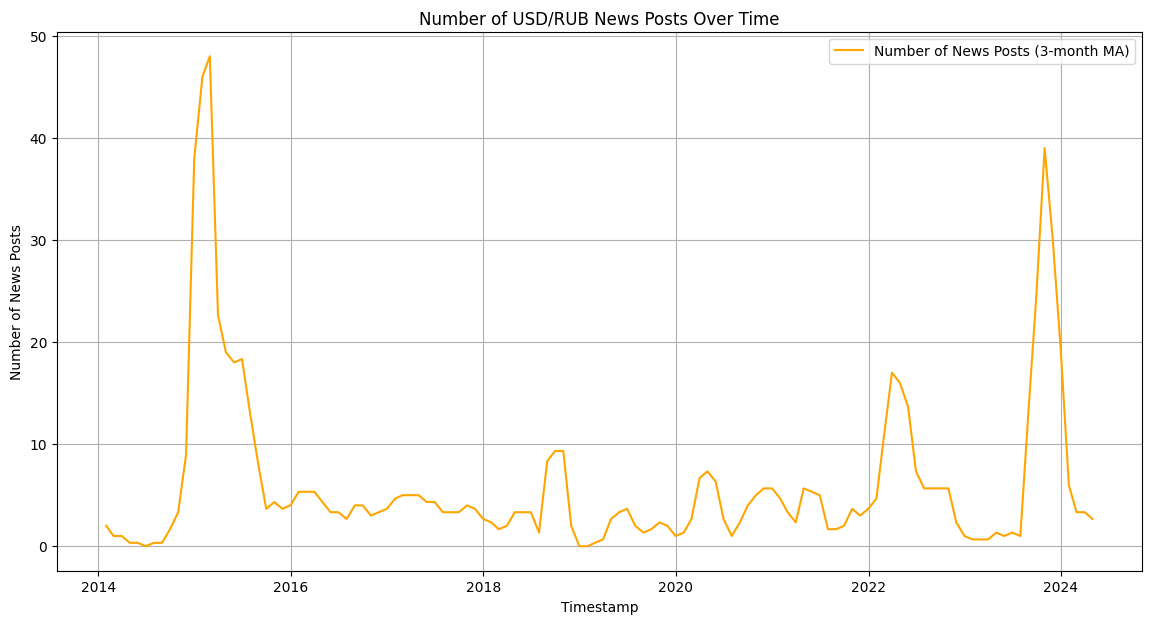

In [ ]:
# Visualize the number of news posts over time
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Calculate the number of news posts per month
monthly_news_count = combined_data.set_index('timestamp').resample('M').size()

# Apply a 3-month moving average for smoothing
smoothed_news_count = monthly_news_count.rolling(window=3, min_periods=1).mean()

# Plot the number of news posts over time
plt.figure(figsize=(14, 7))
plt.plot(smoothed_news_count.index, smoothed_news_count.values, label='Number of News Posts (3-month MA)', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Number of News Posts')
plt.title('Number of USD/RUB News Posts Over Time')
plt.legend()
plt.grid(True)
plt.show()


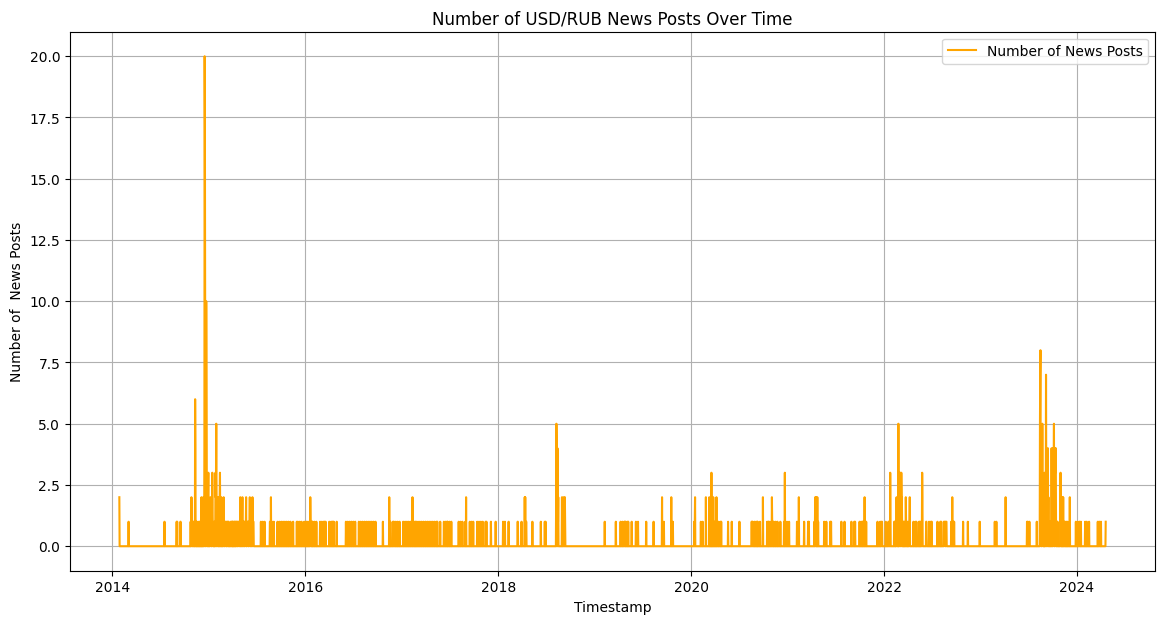

In [ ]:
# Visualize the number of news posts over time
combined_data.set_index('timestamp', inplace=True)
news_counts = combined_data.resample('D').size()

plt.figure(figsize=(14, 7))
plt.plot(news_counts.index, news_counts.values, label='Number of News Posts', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Number of  News Posts')
plt.title('Number of USD/RUB News Posts Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Feature Engineering
combined_data['daily_return'] = combined_data['close'].pct_change()
combined_data['volatility'] = combined_data['daily_return'].rolling(window=30).std()


In [ ]:
# Reset index to access the timestamp for visualization
combined_data.reset_index(inplace=True)

# Display the first few rows to confirm the new features
print("Combined Data with New Features:")
print(combined_data[['timestamp', 'close', 'daily_return', 'volatility']].head())

Combined Data with New Features:
   timestamp    close  daily_return  volatility
0 2024-04-19  93.1525           NaN         NaN
1 2024-04-01  92.1425     -0.010842         NaN
2 2024-03-26  92.7000      0.006050         NaN
3 2024-03-25  92.5800     -0.001294         NaN
4 2024-03-20  92.2500     -0.003564         NaN


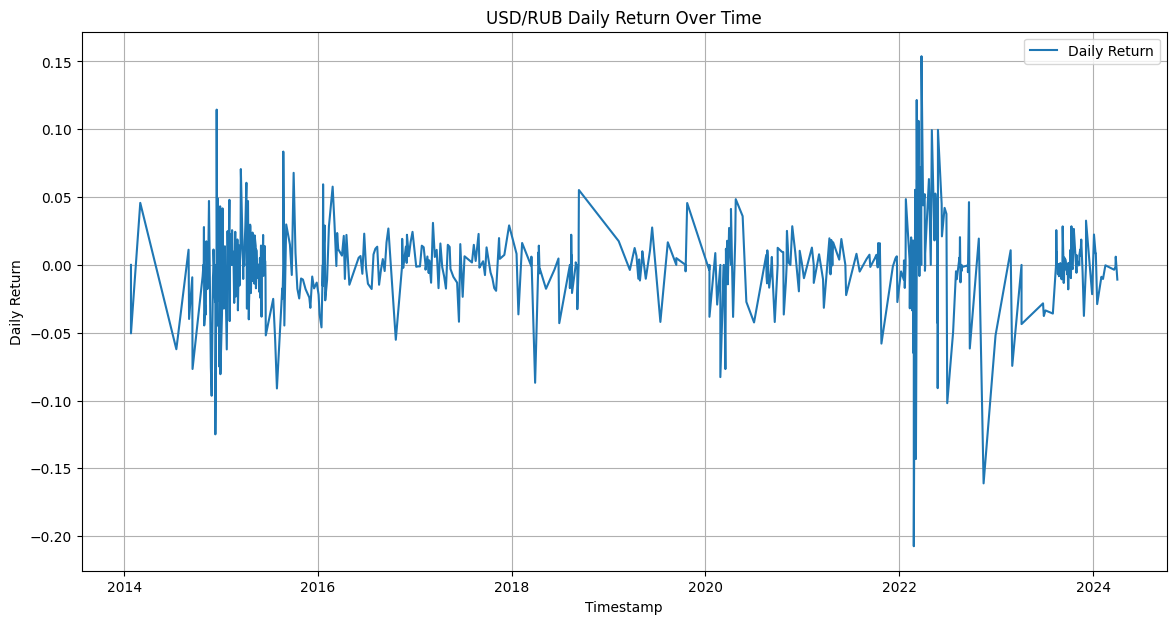

In [ ]:
# Visualize the daily return
plt.figure(figsize=(14, 7))
plt.plot(combined_data['timestamp'], combined_data['daily_return'], label='Daily Return')
plt.xlabel('Timestamp')
plt.ylabel('Daily Return')
plt.title('USD/RUB Daily Return Over Time')
plt.legend()
plt.grid(True)
plt.show()


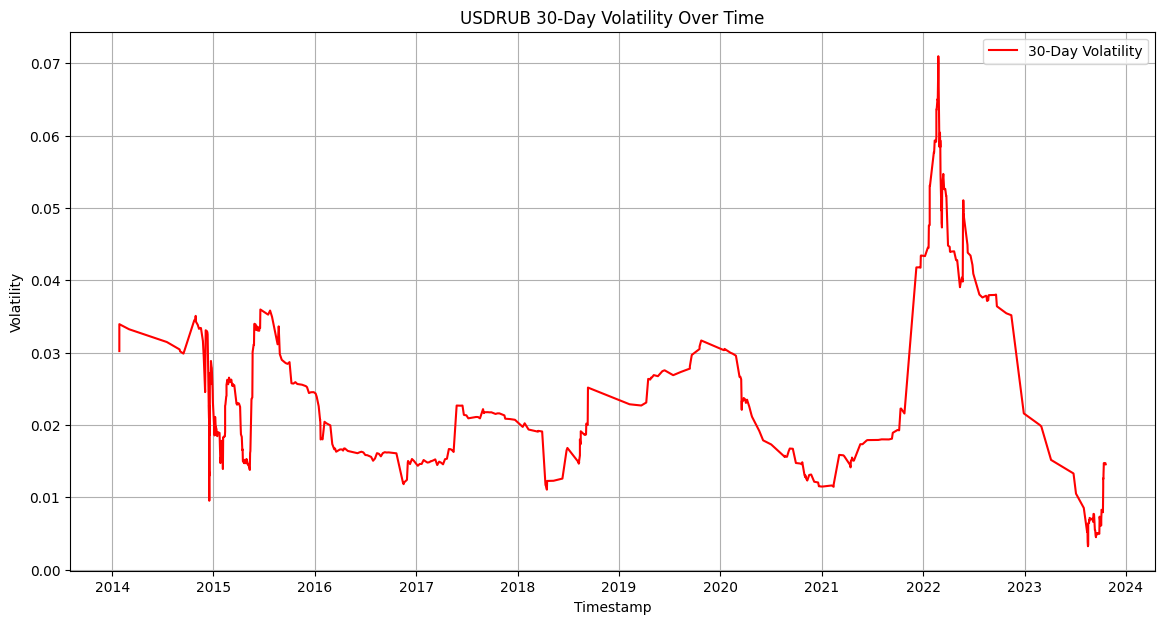

In [ ]:
# Visualize the volatility
plt.figure(figsize=(14, 7))
plt.plot(combined_data['timestamp'], combined_data['volatility'], label='30-Day Volatility', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Volatility')
plt.title('USDRUB 30-Day Volatility Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load FinBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Sentiment analysis pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to get sentiment
def get_sentiment(text):
    return nlp(text)[0]['label']

# Apply sentiment analysis on the 'comment' column
combined_data['sentiment'] = combined_data['comment'].apply(get_sentiment)

# Convert sentiment to score
def sentiment_to_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0

combined_data['sentiment_score'] = combined_data['sentiment'].apply(sentiment_to_score)

# Display the first few rows to confirm the sentiment scores
print("Combined Data with Sentiment Scores:")
print(combined_data[['timestamp', 'comment', 'sentiment', 'sentiment_score']].head())


Combined Data with Sentiment Scores:
   timestamp                                            comment sentiment  \
0 2024-04-19  MOSCOW (Reuters) - Russian banks' profits fell...  Negative   
1 2024-04-01  MOSCOW (Reuters) - Russia's benchmark stock in...  Positive   
2 2024-03-26  MOSCOW (Reuters) - Russian banks' profits fell...  Negative   
3 2024-03-25  MOSCOW (Reuters) - The rouble hit a one-week l...   Neutral   
4 2024-03-20  MOSCOW (Reuters) - Foreign companies leaving R...   Neutral   

   sentiment_score  
0               -1  
1                1  
2               -1  
3                0  
4                0  


In [ ]:
# Display the first 20 rows to confirm the sentiment scores

print("Combined Data with USD/RUB Sentiment Scores:")
print(combined_data[['timestamp', 'comment', 'sentiment', 'sentiment_score']].head(20).to_markdown())


Combined Data with USD/RUB Sentiment Scores:
|    | timestamp           | comment                                                                                                                                                                                | sentiment   |   sentiment_score |
|---:|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------|------------------:|
|  0 | 2024-04-19 00:00:00 | MOSCOW (Reuters) - Russian banks' profits fell marginally in March to 270 billion roubles ($2.89 billion), slightly lower than the month before, the central bank said on Friday....   | Negative    |                -1 |
|  1 | 2024-04-01 00:00:00 | MOSCOW (Reuters) - Russia's benchmark stock index strengthened to its highest point since the day Russia sent its troops into Ukraine in February 2022 on Monday, while the rouble... 

Unique sentiment labels in the dataset: ['Negative' 'Positive' 'Neutral']


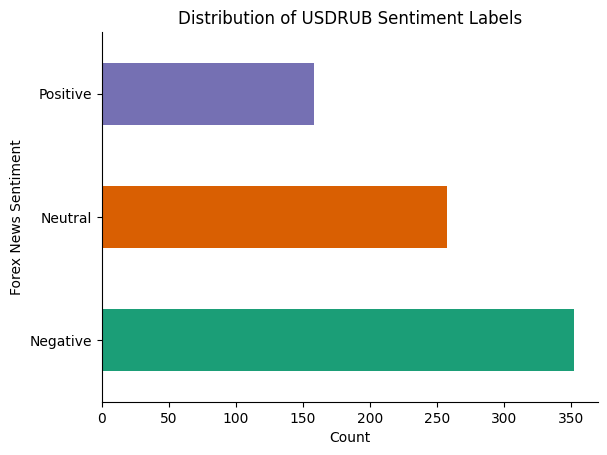

In [ ]:
# @title sentiment
combined_data['sentiment_label'] = combined_data['sentiment_score'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))

# Check the unique values in the sentiment_label column
unique_sentiments = combined_data['sentiment_label'].unique()
print("Unique sentiment labels in the dataset:", unique_sentiments)

# Group by sentiment label and plot the count of each label
combined_data.groupby('sentiment_label').size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.xlabel('Count')
plt.ylabel('Forex News Sentiment')
plt.title('Distribution of USDRUB Sentiment Labels')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

<ipython-input-138-46e4c54571f6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_data, x='sentiment', palette='Dark2')


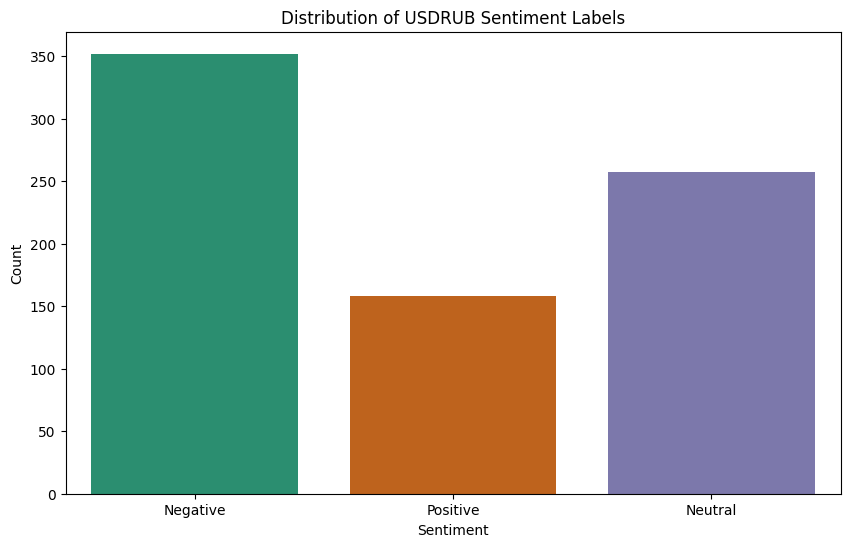

In [ ]:
# Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_data, x='sentiment', palette='Dark2')
plt.title('Distribution of USDRUB Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


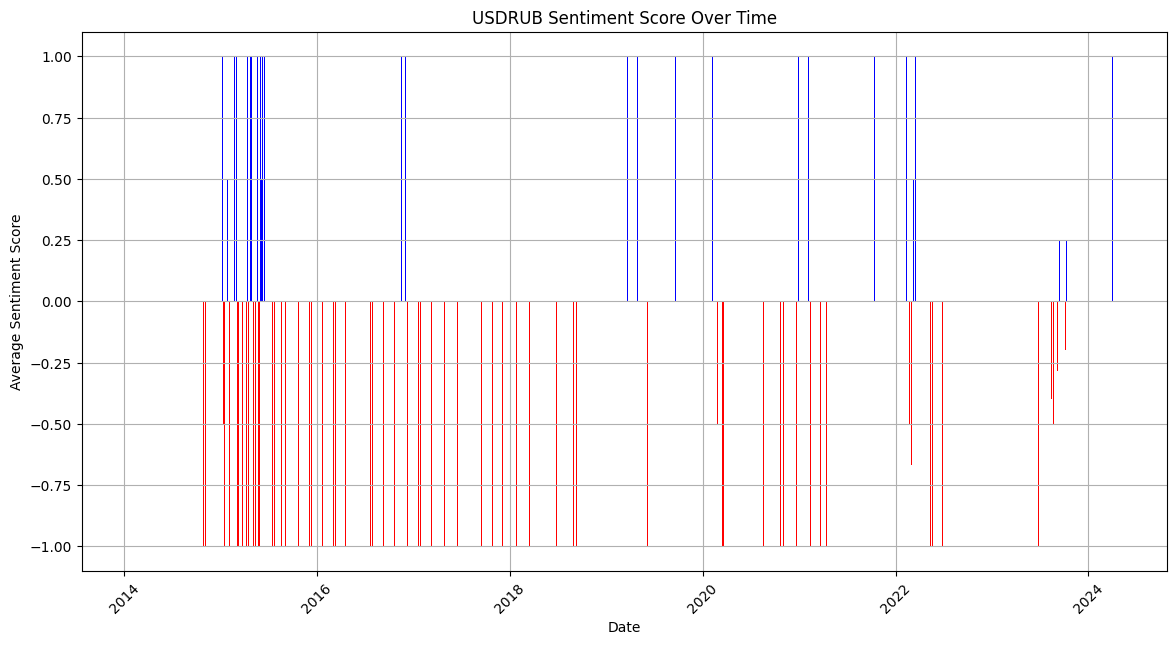

In [ ]:
# Convert timestamp to datetime and extract date
combined_data['date'] = pd.to_datetime(combined_data['timestamp']).dt.date

# Calculate the daily mean sentiment scores
daily_sentiment = combined_data.groupby('date')['sentiment_score'].mean()

# Define conditions for color coding
colors = daily_sentiment.apply(lambda x: 'blue' if x > 0 else ('red' if x < 0 else 'grey'))

# Plotting with color coding
plt.figure(figsize=(14, 7))
for date, sentiment, color in zip(daily_sentiment.index, daily_sentiment.values, colors):
    plt.bar(date, sentiment, color=color)

# Formatting the plot
plt.title('USDRUB Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


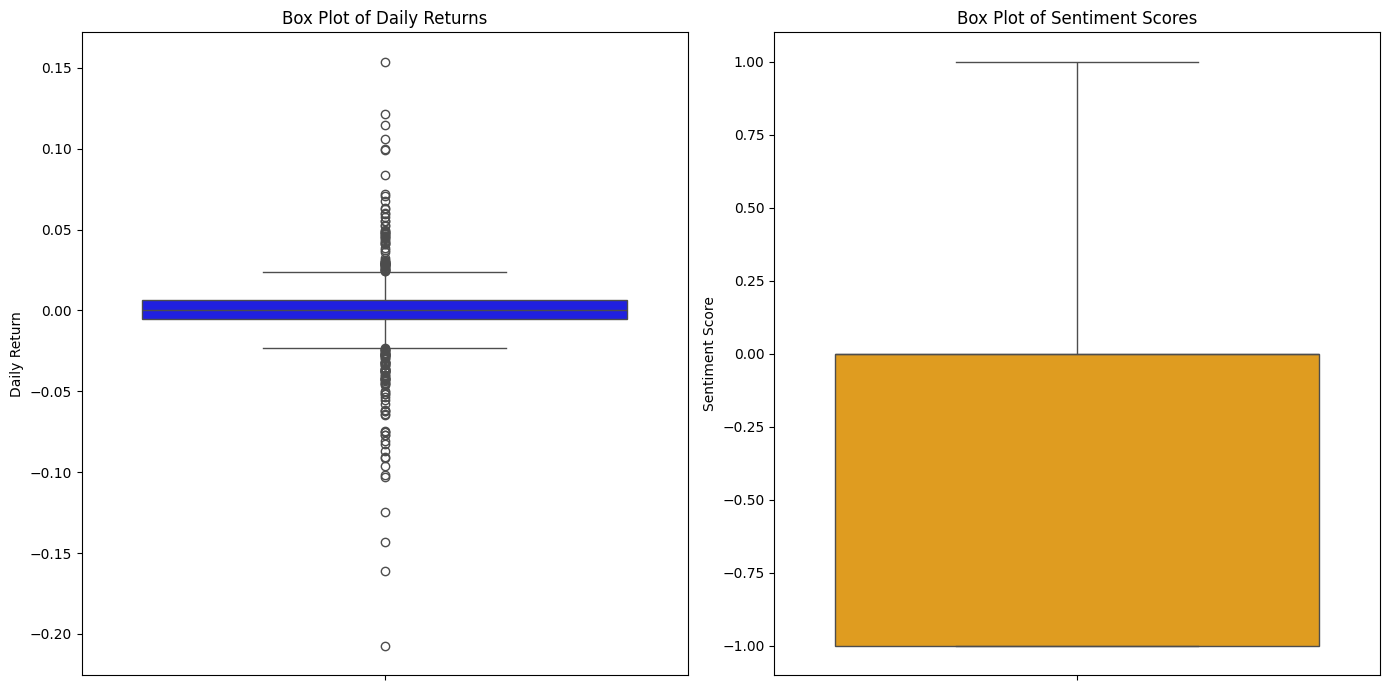

In [ ]:
# Plotting the box plots for daily returns and sentiment scores
plt.figure(figsize=(14, 7))

# Subplot for daily return
plt.subplot(1, 2, 1)
sns.boxplot(data=combined_data, y='daily_return', color='blue')
plt.title('Box Plot of Daily Returns')
plt.ylabel('Daily Return')

# Subplot for sentiment score
plt.subplot(1, 2, 2)
sns.boxplot(data=combined_data, y='sentiment_score', color='orange')
plt.title('Box Plot of Sentiment Scores')
plt.ylabel('Sentiment Score')

plt.tight_layout()
plt.show()


In [ ]:
# Categorize sentiment scores
combined_data['sentiment_category'] = combined_data['sentiment_score'].apply(
    lambda x: 'positive' if x > 0.5 else ('neutral' if x == 0.5 else 'negative')
)

# Calculate summary statistics for 'close', 'daily_return', and 'sentiment_score'
summary_stats = combined_data[['close', 'daily_return', 'sentiment_score']].describe()

# Add count of each sentiment category to the summary table
sentiment_counts = combined_data['sentiment_category'].value_counts().rename('count').to_frame()

# Concatenate the summary statistics and sentiment counts
summary_stats = pd.concat([summary_stats, sentiment_counts.T])

# Print the summary statistics table in a formatted way using tabulate
print(tabulate(summary_stats, headers='keys', tablefmt='psql'))


+-------+----------+----------------+-------------------+------------+------------+
|       |    close |   daily_return |   sentiment_score |   negative |   positive |
|-------+----------+----------------+-------------------+------------+------------|
| count | 767      |  766           |        767        |        nan |        nan |
| mean  |  71.411  |   -0.000923979 |         -0.252934 |        nan |        nan |
| std   |  17.2213 |    0.026722    |          0.775717 |        nan |        nan |
| min   |  34.688  |   -0.207402    |         -1        |        nan |        nan |
| 25%   |  59.7195 |   -0.00552159  |         -1        |        nan |        nan |
| 50%   |  66.6899 |    0           |          0        |        nan |        nan |
| 75%   |  79.4404 |    0.0063483   |          0        |        nan |        nan |
| max   | 143      |    0.153846    |          1        |        nan |        nan |
| count | nan      |  nan           |        nan        |        609 |      

In [ ]:
# Categorize sentiment scores
combined_data['sentiment_category'] = combined_data['sentiment_score'].apply(
    lambda x: 'positive' if x > 0.5 else ('neutral' if x == 0.5 else 'negative')
)

# Calculate summary statistics for 'close', 'daily_return', and 'sentiment_score'
summary_stats = combined_data[['close', 'daily_return', 'sentiment_score']].describe()

# Add count of each sentiment category to the summary table
sentiment_counts = combined_data['sentiment_category'].value_counts().rename('count').to_frame()

# Concatenate the summary statistics and sentiment counts
summary_stats = pd.concat([summary_stats, sentiment_counts.T])

# Display the summary statistics table
from IPython.display import display, HTML

# Convert the summary stats DataFrame to an HTML table and display it
display(HTML(summary_stats.to_html()))

# Print the summary statistics for environments where HTML display is not supported
print(summary_stats)


,close,daily_return,sentiment_score,negative,positive
count,767.000000,766.000000,767.000000,NaN,NaN
mean,71.410958,-0.000924,-0.252934,NaN,NaN
std,17.221280,0.026722,0.775717,NaN,NaN
min,34.688000,-0.207402,-1.000000,NaN,NaN
25%,59.719500,-0.005522,-1.000000,NaN,NaN
50%,66.689900,0.000000,0.000000,NaN,NaN
75%,79.440450,0.006348,0.000000,NaN,NaN
max,143.000000,0.153846,1.000000,NaN,NaN
count,NaN,NaN,NaN,609.0,158.0


            close  daily_return  sentiment_score  negative  positive
count  767.000000    766.000000       767.000000       NaN       NaN
mean    71.410958     -0.000924        -0.252934       NaN       NaN
std     17.221280      0.026722         0.775717       NaN       NaN
min     34.688000     -0.207402        -1.000000       NaN       NaN
25%     59.719500     -0.005522        -1.000000       NaN       NaN
50%     66.689900      0.000000         0.000000       NaN       NaN
75%     79.440450      0.006348         0.000000       NaN       NaN
max    143.000000      0.153846         1.000000       NaN       NaN
count         NaN           NaN              NaN     609.0     158.0


Aggregation

In [ ]:
# Convert 'change_pct' column to string values
combined_data['change_pct'] = combined_data['change_pct'].astype(str)

# Remove '%' symbol and convert to numeric values
combined_data['change_pct'] = combined_data['change_pct'].str.replace('%', '')
combined_data['change_pct'] = pd.to_numeric(combined_data['change_pct'], errors='coerce')

# Verify the conversion
print("Combined Data after converting 'change_pct' to numeric:")
print(combined_data[['change_pct']].head())

Combined Data after converting 'change_pct' to numeric:
   change_pct
0       -0.67
1       -0.36
2        0.13
3       -0.23
4       -0.43


In [ ]:
# Select only numeric columns for aggregation
numeric_columns = combined_data.select_dtypes(include=['number']).columns

# Verify the numeric columns
print("Numeric columns in combined_data:")
print(numeric_columns)


Numeric columns in combined_data:
Index(['close', 'open', 'high', 'low', 'volume', 'change_pct', 'daily_return',
       'volatility', 'sentiment_score'],
      dtype='object')


In [ ]:
# Aggregation of numeric columns only
weekly_sentiment = combined_data.set_index('timestamp')[numeric_columns].resample('W').mean()
monthly_forex_data = combined_data.set_index('timestamp')[numeric_columns].resample('M').mean()

# Display the aggregated data
print("Weekly Sentiment:")
print(weekly_sentiment.head())

print("\nMonthly Forex Data:")
print(monthly_forex_data.head())

Weekly Sentiment:
             close    open    high    low  volume  change_pct  daily_return  \
timestamp                                                                     
2014-02-02  34.688  34.495  34.863  34.41     NaN        0.52     -0.025238   
2014-02-09     NaN     NaN     NaN    NaN     NaN         NaN           NaN   
2014-02-16     NaN     NaN     NaN    NaN     NaN         NaN           NaN   
2014-02-23     NaN     NaN     NaN    NaN     NaN         NaN           NaN   
2014-03-02     NaN     NaN     NaN    NaN     NaN         NaN           NaN   

            volatility  sentiment_score  
timestamp                                
2014-02-02    0.032083             -0.5  
2014-02-09         NaN              NaN  
2014-02-16         NaN              NaN  
2014-02-23         NaN              NaN  
2014-03-02         NaN              NaN  

Monthly Forex Data:
             close    open    high    low  volume  change_pct  daily_return  \
timestamp                         

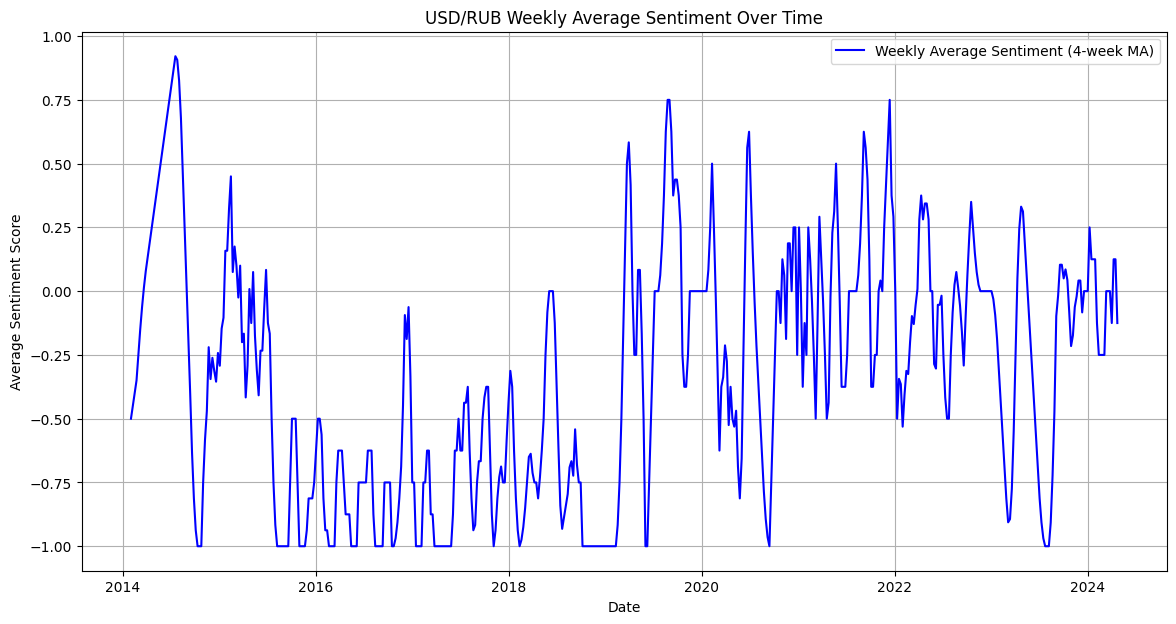

In [ ]:
# Visualize the weekly average sentiment

combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Resample the data to weekly frequency and calculate the mean sentiment score
weekly_sentiment = combined_data.set_index('timestamp')['sentiment_score'].resample('W').mean()

# Interpolate missing values to make the line smoother
interpolated_sentiment = weekly_sentiment.interpolate(method='linear')

# Apply a 4-week moving average for additional smoothing
smoothed_sentiment = interpolated_sentiment.rolling(window=4, min_periods=1).mean()

# Plot the sentiment scores over time
plt.figure(figsize=(14, 7))
plt.plot(smoothed_sentiment.index, smoothed_sentiment.values, label='Weekly Average Sentiment (4-week MA)', color='blue')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('USD/RUB Weekly Average Sentiment Over Time')
plt.legend()
plt.grid(True)
plt.show()


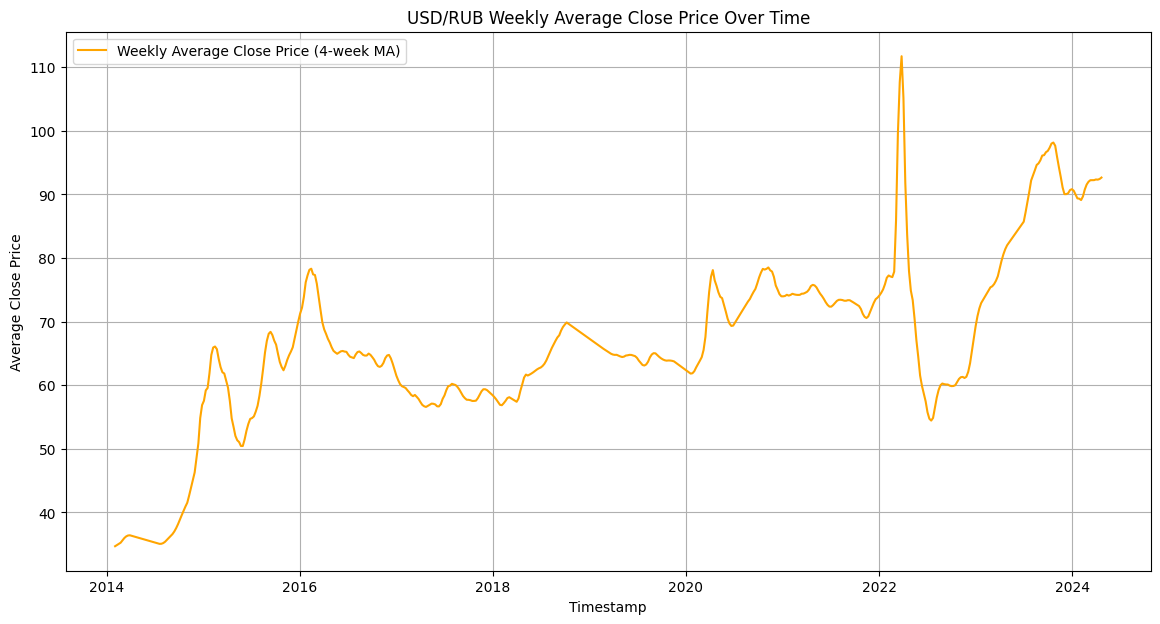

In [ ]:
# Visualize the weekly average close price
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Resample the data to weekly frequency and calculate the mean close price
weekly_close = combined_data.set_index('timestamp')['close'].resample('W').mean()

# Interpolate missing values to make the line smoother
interpolated_close = weekly_close.interpolate(method='linear')

# Apply a 4-week moving average for additional smoothing
smoothed_close = interpolated_close.rolling(window=4, min_periods=1).mean()

# Plot the close prices over time
plt.figure(figsize=(14, 7))
plt.plot(smoothed_close.index, smoothed_close.values, label='Weekly Average Close Price (4-week MA)', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Average Close Price')
plt.title('USD/RUB Weekly Average Close Price Over Time')
plt.legend()
plt.grid(True)
plt.show()


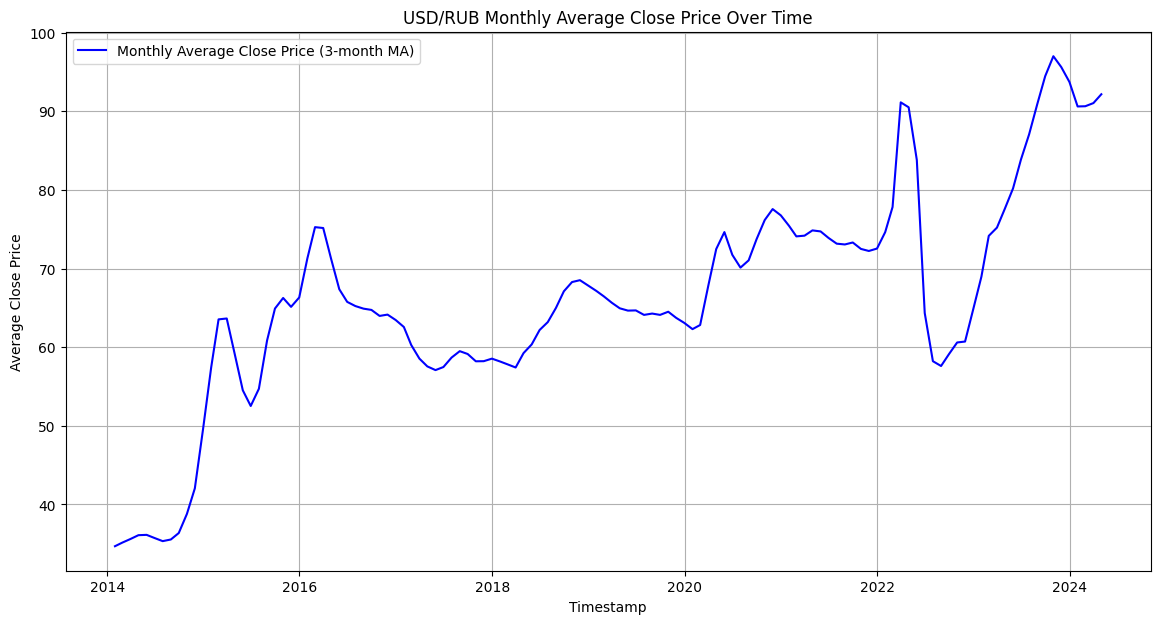

In [ ]:
# Visualize the monthly average close price
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Resample the data to monthly frequency and calculate the mean close price
monthly_close = combined_data.set_index('timestamp')['close'].resample('M').mean()

# Interpolate missing values to make the line smoother
interpolated_close = monthly_close.interpolate(method='linear')

# Apply a 3-month moving average for additional smoothing
smoothed_close = interpolated_close.rolling(window=3, min_periods=1).mean()

# Plot the close prices over time
plt.figure(figsize=(14, 7))
plt.plot(smoothed_close.index, smoothed_close.values, label='Monthly Average Close Price (3-month MA)', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Average Close Price')
plt.title('USD/RUB Monthly Average Close Price Over Time')
plt.legend()
plt.grid(True)
plt.show()


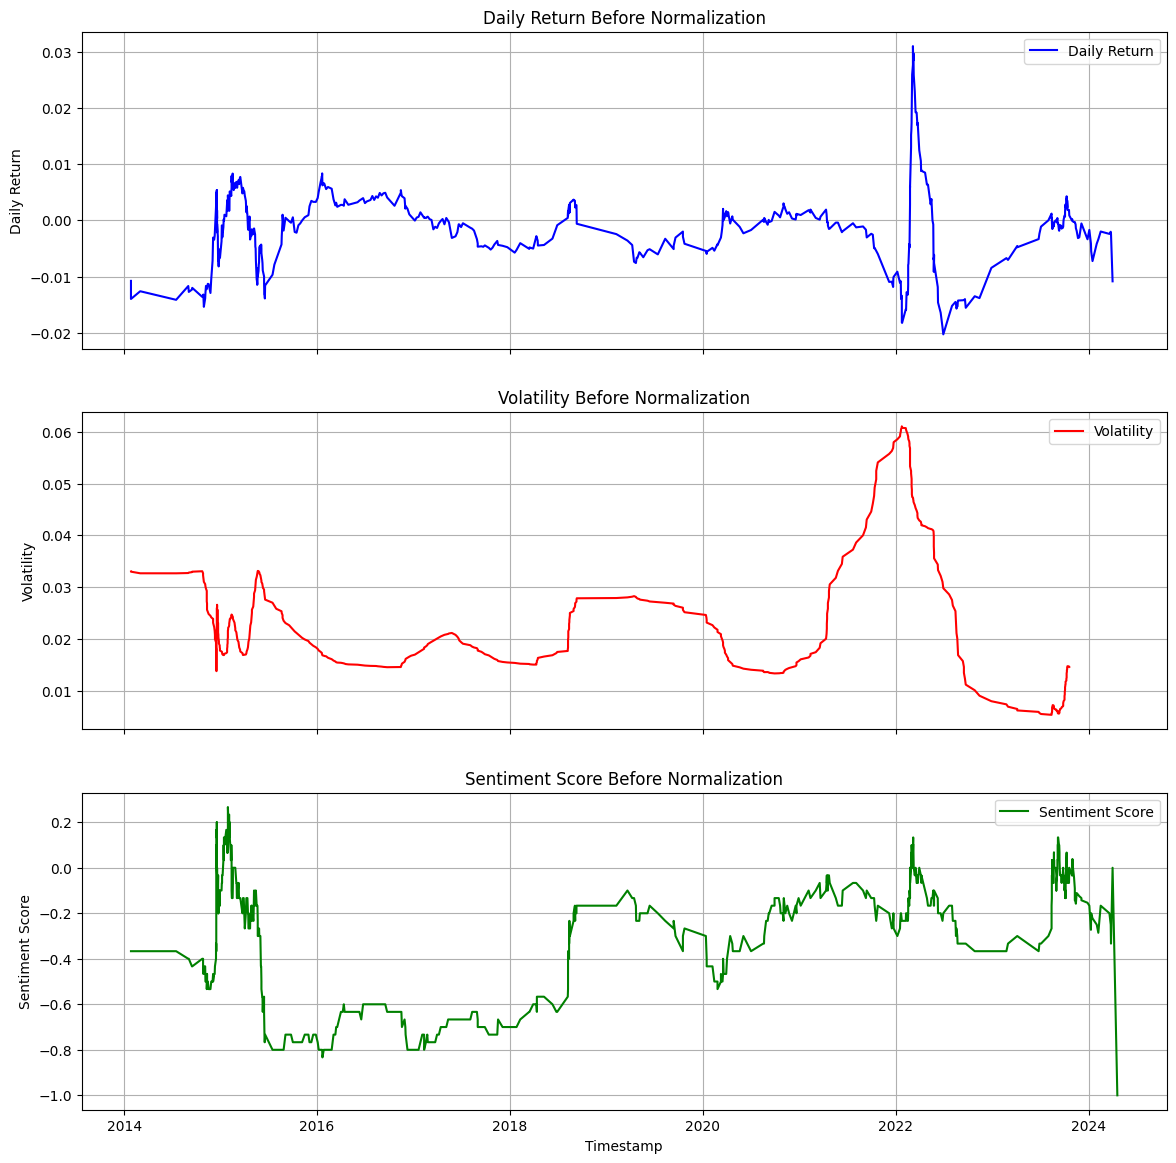

In [ ]:
# Plot the distribution of features before normalization
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Calculate daily return
daily_return = combined_data.set_index('timestamp')['daily_return']

# Calculate volatility (using a rolling standard deviation as a simple measure of volatility)
volatility = daily_return.rolling(window=30).std()

# Calculate sentiment score
sentiment_score = combined_data.set_index('timestamp')['sentiment_score']

# Interpolate missing values for sentiment score
interpolated_sentiment = sentiment_score.interpolate(method='linear')

# Smooth the data using a rolling average
smoothed_daily_return = daily_return.rolling(window=30, min_periods=1).mean()
smoothed_volatility = volatility.rolling(window=30, min_periods=1).mean()
smoothed_sentiment = interpolated_sentiment.rolling(window=30, min_periods=1).mean()

# Plot the data
fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

# Daily Return
axs[0].plot(smoothed_daily_return.index, smoothed_daily_return.values, label='Daily Return', color='blue')
axs[0].set_ylabel('Daily Return')
axs[0].set_title('Daily Return Before Normalization')
axs[0].legend()
axs[0].grid(True)

# Volatility
axs[1].plot(smoothed_volatility.index, smoothed_volatility.values, label='Volatility', color='red')
axs[1].set_ylabel('Volatility')
axs[1].set_title('Volatility Before Normalization')
axs[1].legend()
axs[1].grid(True)

# Sentiment Score
axs[2].plot(smoothed_sentiment.index, smoothed_sentiment.values, label='Sentiment Score', color='green')
axs[2].set_ylabel('Sentiment Score')
axs[2].set_title('Sentiment Score Before Normalization')
axs[2].legend()
axs[2].grid(True)

plt.xlabel('Timestamp')
plt.show()


Normalization

In [ ]:
# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
combined_data[['daily_return', 'volatility', 'sentiment_score']] = scaler.fit_transform(combined_data[['daily_return', 'volatility', 'sentiment_score']])



Text(0.5, 0, 'Timestamp')

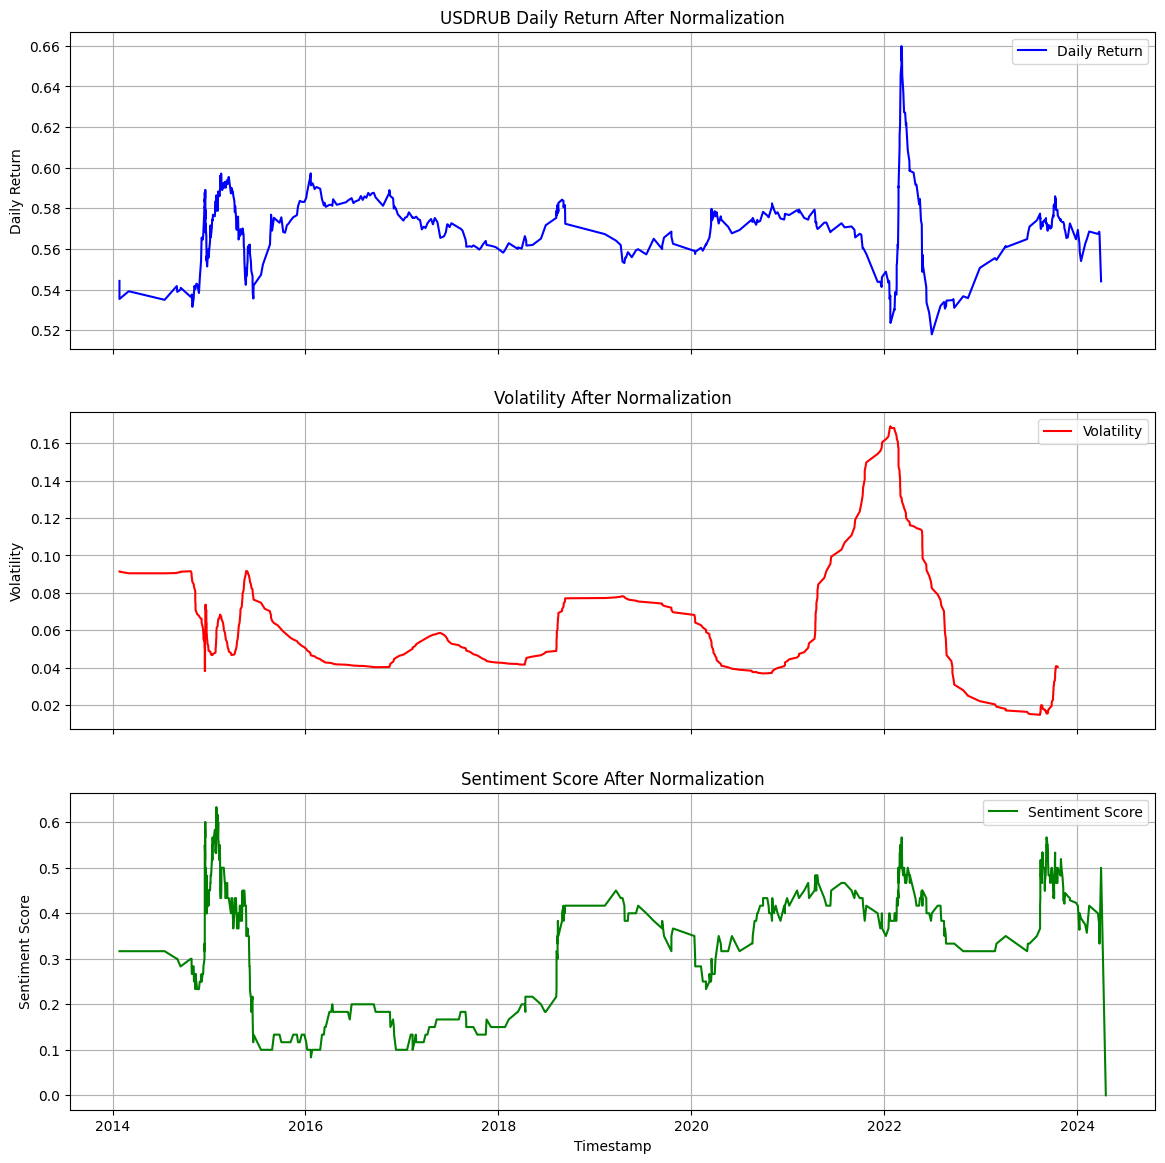

In [ ]:
# Plot the distribution of features after normalization
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Calculate daily return
daily_return = combined_data.set_index('timestamp')['daily_return']

# Calculate volatility (using a rolling standard deviation as a simple measure of volatility)
volatility = daily_return.rolling(window=30).std()

# Calculate sentiment score
sentiment_score = combined_data.set_index('timestamp')['sentiment_score']

# Interpolate missing values for sentiment score
interpolated_sentiment = sentiment_score.interpolate(method='linear')

# Smooth the data using a rolling average
smoothed_daily_return = daily_return.rolling(window=30, min_periods=1).mean()
smoothed_volatility = volatility.rolling(window=30, min_periods=1).mean()
smoothed_sentiment = interpolated_sentiment.rolling(window=30, min_periods=1).mean()

# Plot the data
fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

# Daily Return
axs[0].plot(smoothed_daily_return.index, smoothed_daily_return.values, label='Daily Return', color='blue')
axs[0].set_ylabel('Daily Return')
axs[0].set_title('USDRUB Daily Return After Normalization')
axs[0].legend()
axs[0].grid(True)

# Volatility
axs[1].plot(smoothed_volatility.index, smoothed_volatility.values, label='Volatility', color='red')
axs[1].set_ylabel('Volatility')
axs[1].set_title('Volatility After Normalization')
axs[1].legend()
axs[1].grid(True)

# Sentiment Score
axs[2].plot(smoothed_sentiment.index, smoothed_sentiment.values, label='Sentiment Score', color='green')
axs[2].set_ylabel('Sentiment Score')
axs[2].set_title('Sentiment Score After Normalization')
axs[2].legend()
axs[2].grid(True)

plt.xlabel('Timestamp')

In [ ]:
# Fill NaN values with the mean of each column
combined_data[['daily_return', 'volatility', 'sentiment_score']] = combined_data[['daily_return', 'volatility', 'sentiment_score']].fillna(combined_data[['daily_return', 'volatility', 'sentiment_score']].mean())

# Verify there are no more NaN values
print(combined_data[['daily_return', 'volatility', 'sentiment_score']].isna().sum())

daily_return       0
volatility         0
sentiment_score    0
dtype: int64


In [ ]:
# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(combined_data[['daily_return', 'volatility', 'sentiment_score']])
combined_data_pca = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

# Add the timestamp for reference
combined_data_pca['timestamp'] = combined_data['timestamp'].values

# Display the first few rows to confirm the new PCA components
print("Combined Data with PCA Components:")
print(combined_data_pca.head())

Combined Data with PCA Components:
   principal_component_1  principal_component_2  timestamp
0              -0.373441               0.006389 2024-04-19
1               0.625930              -0.010164 2024-04-01
2              -0.373172               0.006001 2024-03-26
3               0.126421              -0.002142 2024-03-25
4               0.126334              -0.002016 2024-03-20


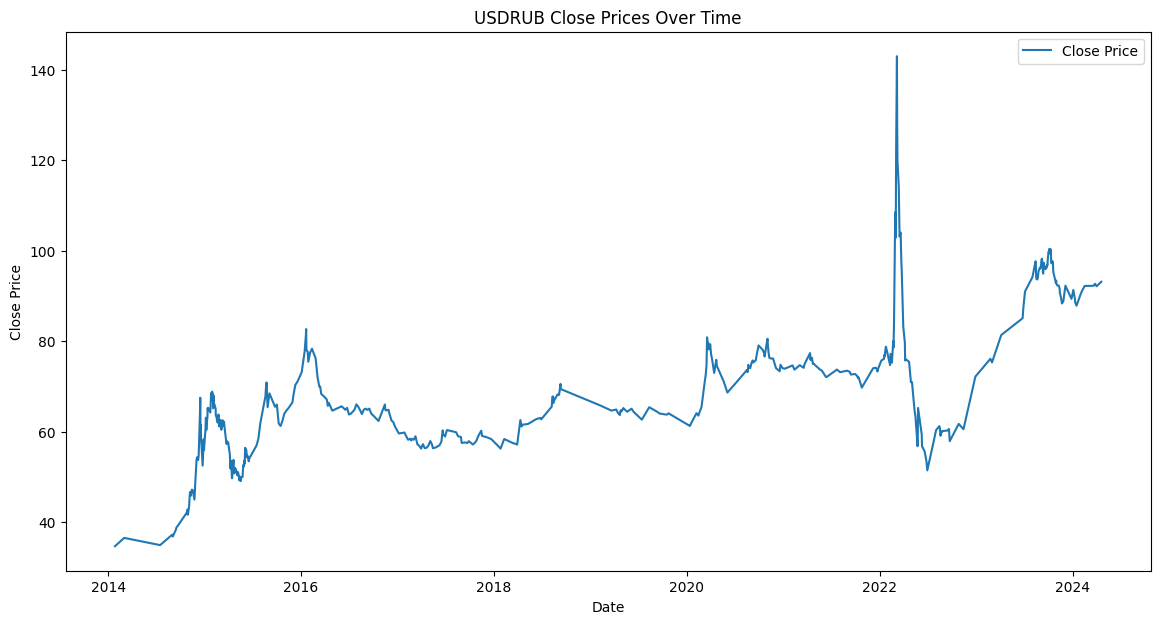

In [ ]:
# Enhanced Exploratory Data Analysis (EDA)
plt.figure(figsize=(14, 7))
plt.plot(combined_data['timestamp'], combined_data['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('USDRUB Close Prices Over Time')
plt.legend()
plt.show()

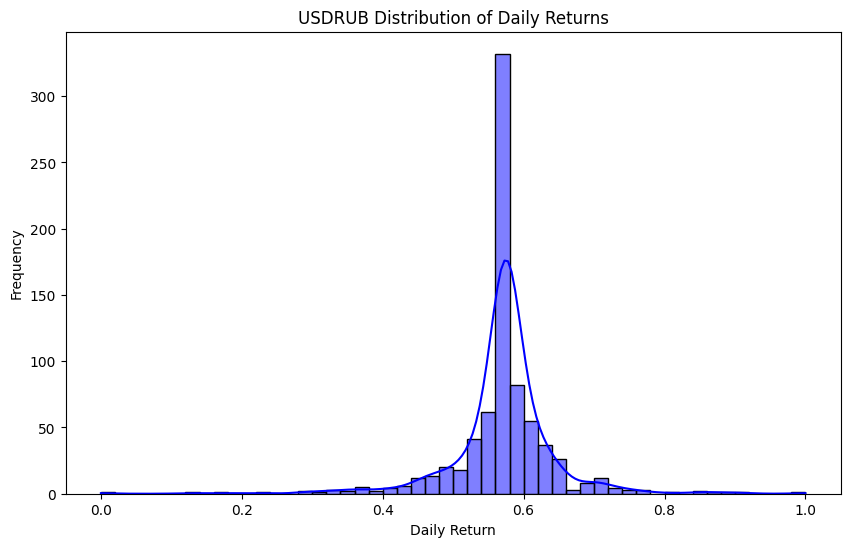

In [ ]:
# Let's ensure the 'daily_return' column exists and is clean

# Plot the histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['daily_return'], kde=True, bins=50, color='blue')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('USDRUB Distribution of Daily Returns')
plt.show()


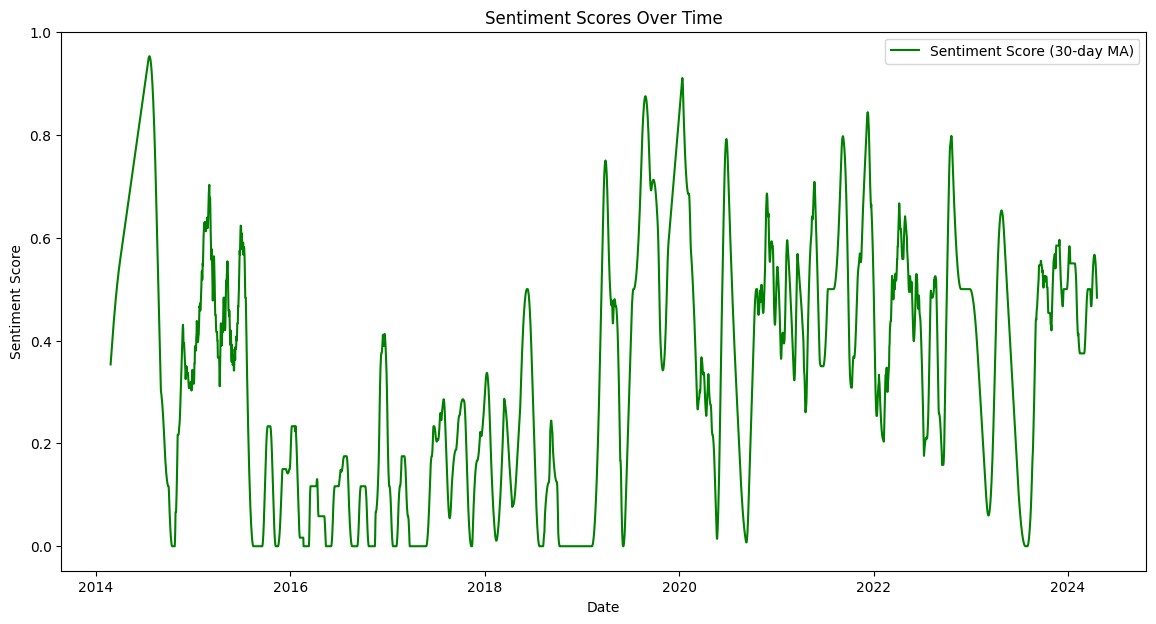

In [ ]:
# Sentiment score overtime
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Resample the data to daily frequency and interpolate missing values for smoother lines
daily_sentiment = combined_data.set_index('timestamp')['sentiment_score'].resample('D').mean().interpolate(method='linear')

# Smooth the data using a rolling average
smoothed_sentiment = daily_sentiment.rolling(window=30).mean()

# Plot the sentiment scores over time
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, smoothed_sentiment.values, label='Sentiment Score (30-day MA)', color='green')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores Over Time')
plt.legend()
plt.show()



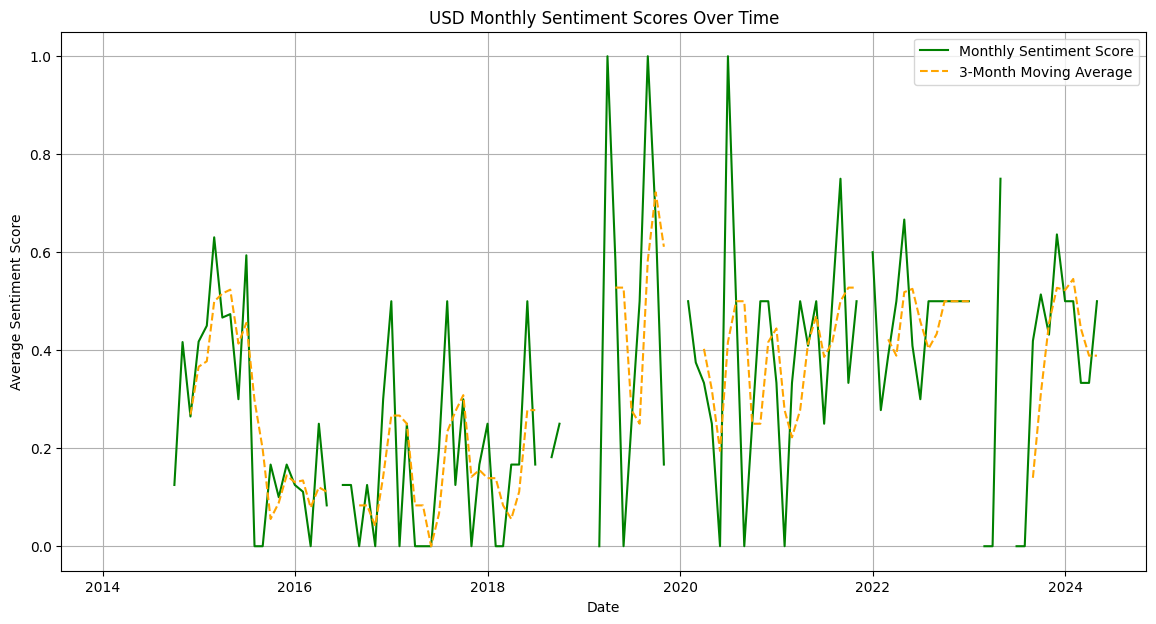

In [ ]:
#Monthly setiment overtime
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Resample the data to monthly frequency and calculate the mean sentiment score
monthly_sentiment = combined_data.set_index('timestamp')['sentiment_score'].resample('M').mean()

# Calculate a 3-month moving average
moving_avg = monthly_sentiment.rolling(window=3).mean()

# Plot the resampled sentiment scores and the moving average
plt.figure(figsize=(14, 7))
plt.plot(monthly_sentiment, label='Monthly Sentiment Score', color='green')
plt.plot(moving_avg, label='3-Month Moving Average', color='orange', linestyle='--')

# Formatting the plot
plt.title('USD Monthly Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


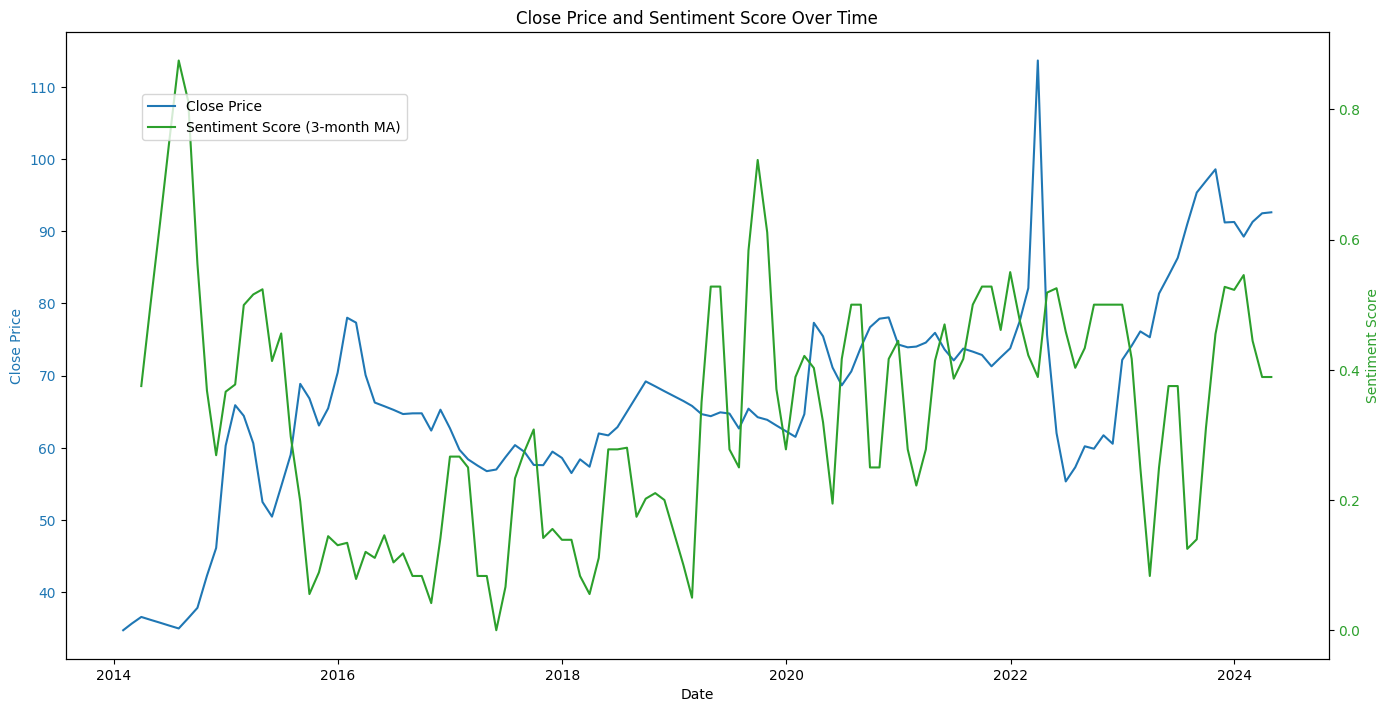

In [ ]:
#Colse price and sentiment overtime

combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Resample the data to monthly frequency and calculate the mean sentiment score and close price
monthly_sentiment = combined_data.set_index('timestamp')['sentiment_score'].resample('M').mean().interpolate()
monthly_close = combined_data.set_index('timestamp')['close'].resample('M').mean().interpolate()

# Calculate a 3-month moving average
sentiment_moving_avg = monthly_sentiment.rolling(window=3).mean()

# Visualize sentiment trend and correlation with historical data
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(monthly_close.index, monthly_close.values, color=color, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(monthly_sentiment.index, sentiment_moving_avg.values, color=color, label='Sentiment Score (3-month MA)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Close Price and Sentiment Score Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


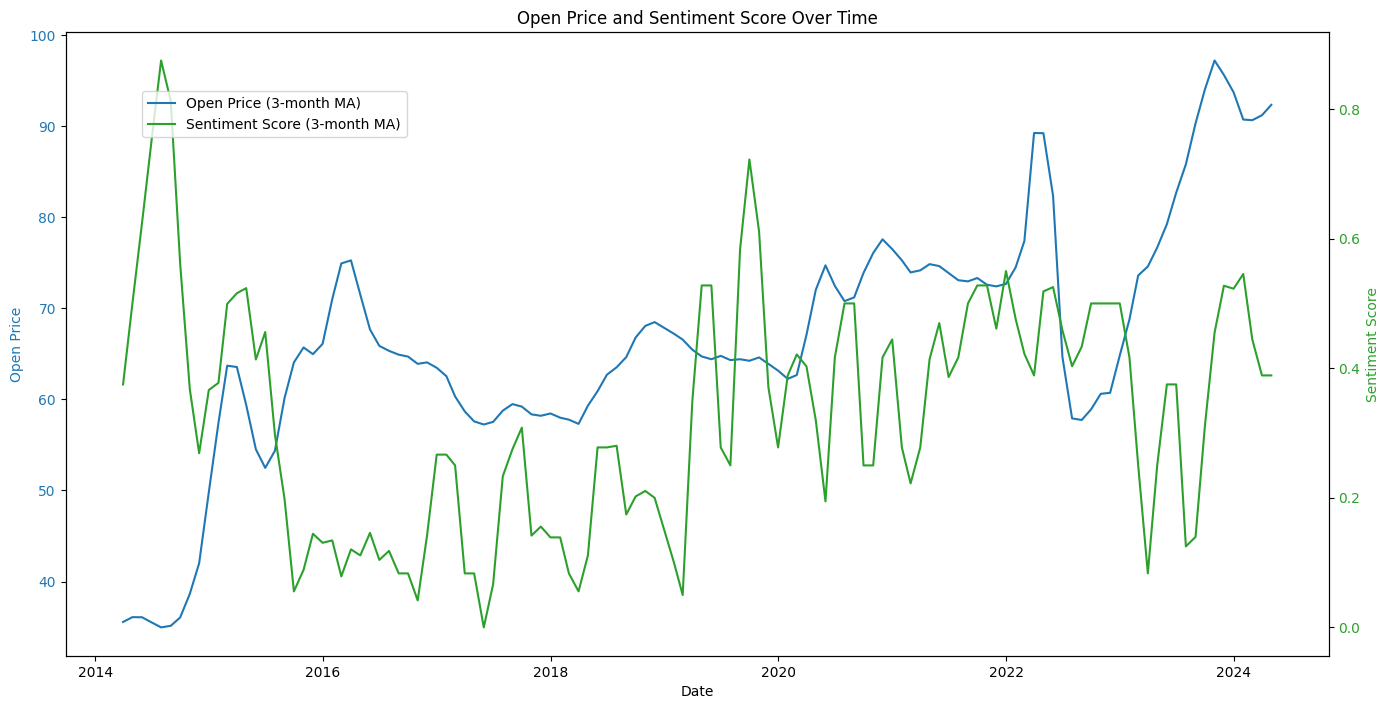

In [ ]:
#Open price and sentiment overtime
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Resample the data to monthly frequency and calculate the mean sentiment score and open price
monthly_sentiment = combined_data.set_index('timestamp')['sentiment_score'].resample('M').mean().interpolate(method='linear')
monthly_close = combined_data.set_index('timestamp')['open'].resample('M').mean().interpolate(method='linear')

# Calculate a 3-month moving average for smoothing
sentiment_moving_avg = monthly_sentiment.rolling(window=3).mean()
close_moving_avg = monthly_close.rolling(window=3).mean()

# Visualize sentiment trend and correlation with historical data
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price', color=color)
ax1.plot(close_moving_avg.index, close_moving_avg.values, color=color, label='Open Price (3-month MA)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(sentiment_moving_avg.index, sentiment_moving_avg.values, color=color, label='Sentiment Score (3-month MA)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Open Price and Sentiment Score Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


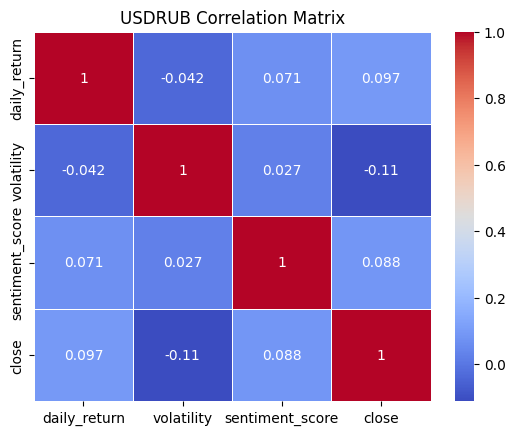

In [ ]:
# Correlation Analysis
corr_matrix = combined_data[['daily_return', 'volatility', 'sentiment_score', 'close']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('USDRUB Correlation Matrix')
plt.show()

In [ ]:
combined_data.head()

,timestamp,close,open,high,low,volume,change_pct,title,comment,daily_return,volatility,sentiment,sentiment_score,sentiment_label,date,sentiment_category
0,2024-04-19,93.1525,93.7800,94.0117,92.9257,NaN,-0.67,Russian banks' profits drop slightly m/m to $2...,MOSCOW (Reuters) - Russian banks' profits fell...,0.571568,0.286475,Negative,0.0,Negative,2024-04-19,negative
1,2024-04-01,92.1425,92.4800,92.4800,92.1425,NaN,-0.36,Russian stocks hit highest in over two years,MOSCOW (Reuters) - Russia's benchmark stock in...,0.544112,0.286475,Positive,1.0,Positive,2024-04-01,positive
2,2024-03-26,92.7000,92.5800,92.8718,92.3600,NaN,0.13,Russian banks' profits drop 22% m/m to $3 bill...,MOSCOW (Reuters) - Russian banks' profits fell...,0.590875,0.286475,Negative,0.0,Negative,2024-03-26,negative
3,2024-03-25,92.5800,92.7950,93.0475,92.5157,NaN,-0.23,Russian rouble hits one-week low vs dollar aft...,MOSCOW (Reuters) - The rouble hit a one-week l...,0.570543,0.286475,Neutral,0.5,Neutral,2024-03-25,negative
4,2024-03-20,92.2500,92.6475,92.8547,92.1976,NaN,-0.43,Foreign firms' Russian 'exit tax' payments at ...,MOSCOW (Reuters) - Foreign companies leaving R...,0.564259,0.286475,Neutral,0.5,Neutral,2024-03-20,negative


Feature Engineering

In [ ]:
# Save the original combined_data to a different variable for later use
comp_data = combined_data.copy()

# Set the timestamp as the index
combined_data.set_index('timestamp', inplace=True)

# Verify the index is set correctly
print(combined_data.index)


DatetimeIndex(['2024-04-19', '2024-04-01', '2024-03-26', '2024-03-25',
               '2024-03-20', '2024-02-16', '2024-02-07', '2024-02-01',
               '2024-01-16', '2024-01-11',
               ...
               '2014-10-27', '2014-10-24', '2014-09-16', '2014-09-15',
               '2014-09-03', '2014-09-01', '2014-07-17', '2014-03-03',
               '2014-01-27', '2014-01-27'],
              dtype='datetime64[ns]', name='timestamp', length=767, freq=None)


In [ ]:
# Feature engineering
combined_data['daily_return'] = combined_data['close'].pct_change()
combined_data['volatility'] = combined_data['daily_return'].rolling(window=30).std()

# Lagged features
for lag in range(1, 6):
    combined_data[f'close_lag_{lag}'] = combined_data['close'].shift(lag)
    combined_data[f'daily_return_lag_{lag}'] = combined_data['daily_return'].shift(lag)

# Handling missing values
combined_data.fillna(method='bfill', inplace=True)

# Drop non-numeric columns except 'timestamp' and check columns
numeric_columns = combined_data.select_dtypes(include=[np.number]).columns
combined_data = combined_data[numeric_columns]

print("Columns in combined_data after dropping non-numeric columns:", combined_data.columns)

# Define the columns to scale
columns_to_scale = ['close', 'daily_return', 'volatility', 'sentiment_score'] + [f'close_lag_{lag}' for lag in range(1, 6)] + [f'daily_return_lag_{lag}' for lag in range(1, 6)]

# Verify if the columns exist in the DataFrame
missing_cols = set(columns_to_scale) - set(combined_data.columns)
if missing_cols:
    print(f"Missing columns in combined_data: {missing_cols}")

# Scaling features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[columns_to_scale])

# Create a DataFrame with scaled features
scaled_data = pd.DataFrame(scaled_features, columns=columns_to_scale, index=combined_data.index)

# Save the scaled_data for modeling
modeling_data = scaled_data.copy()


Columns in combined_data after dropping non-numeric columns: Index(['close', 'open', 'high', 'low', 'volume', 'change_pct', 'daily_return',
       'volatility', 'sentiment_score', 'close_lag_1', 'daily_return_lag_1',
       'close_lag_2', 'daily_return_lag_2', 'close_lag_3',
       'daily_return_lag_3', 'close_lag_4', 'daily_return_lag_4',
       'close_lag_5', 'daily_return_lag_5'],
      dtype='object')


Prepare Data for LSTM

In [ ]:
# Prepare data for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), :]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X, Y = create_dataset(scaled_features, look_back)

# Debug: Check if dataset creation is correct
if X.size == 0 or Y.size == 0:
    print("X or Y is empty after creating dataset.")
else:
    print("X shape:", X.shape)
    print("Y shape:", Y.shape)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Debug: Check training and testing set sizes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X shape: (706, 60, 14)
Y shape: (706,)
X_train shape: (564, 60, 14)
X_test shape: (142, 60, 14)
Y_train shape: (564,)
Y_test shape: (142,)


 LSTM Model Training

In [ ]:
# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, X.shape[2])))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
18/18 [==============================] - 15s 97ms/step - loss: 0.0712
Epoch 2/50
18/18 [==============================] - 2s 104ms/step - loss: 0.0126
Epoch 3/50
18/18 [==============================] - 2s 98ms/step - loss: 0.0086
Epoch 4/50
18/18 [==============================] - 2s 125ms/step - loss: 0.0077
Epoch 5/50
18/18 [==============================] - 3s 156ms/step - loss: 0.0066
Epoch 6/50
18/18 [==============================] - 2s 116ms/step - loss: 0.0057
Epoch 7/50
18/18 [==============================] - 2s 114ms/step - loss: 0.0054
Epoch 8/50
18/18 [==============================] - 2s 116ms/step - loss: 0.0053
Epoch 9/50
18/18 [==============================] - 2s 120ms/step - loss: 0.0049
Epoch 10/50
18/18 [==============================] - 2s 109ms/step - loss: 0.0044
Epoch 11/50
18/18 [==============================] - 3s 177ms/step - loss: 0.0039
Epoch 12/50
18/18 [==============================] - 3s 160ms/step - loss: 0.0042
Epoch 13/50
18/18 [=======

Random Forest Model Training with Hyperparameter Tuning

In [ ]:
# Separate features and target variable
features_rf = combined_data.drop(columns=['close']).values  # Drop target variable
target_rf = combined_data['close'].values

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
features_rf_imputed = imputer.fit_transform(features_rf)

# Split data into training and testing sets
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(features_rf_imputed, target_rf, test_size=0.2, random_state=42)

# Train Random Forest Model with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_rf, Y_train_rf)

best_rf_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.989095130662894


Model Evaluation

In [ ]:
# Predictions
predictions_lstm = model_lstm.predict(X_test)
predictions_rf = best_rf_model.predict(X_test_rf)

# Inverse scaling for LSTM predictions
predictions_lstm = scaler.inverse_transform(np.concatenate((predictions_lstm, X_test[:, -1, 1:]), axis=1))[:, 0]

# Evaluation Metrics
mae_lstm = mean_absolute_error(Y_test, predictions_lstm)
mse_lstm = mean_squared_error(Y_test, predictions_lstm)
rmse_lstm = np.sqrt(mse_lstm)

mae_rf = mean_absolute_error(Y_test_rf, predictions_rf)
mse_rf = mean_squared_error(Y_test_rf, predictions_rf)
rmse_rf = np.sqrt(mse_rf)

print('LSTM MAE:', mae_lstm)
print('LSTM MSE:', mse_lstm)
print('LSTM RMSE:', rmse_lstm)

print('RF MAE:', mae_rf)
print('RF MSE:', mse_rf)
print('RF RMSE:', rmse_rf)

# Convert regression outputs to binary classification for precision, recall, F1 score
threshold = np.median(Y_test)

binary_Y_test = (Y_test > threshold).astype(int)
binary_predictions_lstm = (predictions_lstm > threshold).astype(int)

binary_Y_test_rf = (Y_test_rf > threshold).astype(int)
binary_predictions_rf = (predictions_rf > threshold).astype(int)



5/5 [==============================] - 1s 19ms/step
LSTM MAE: 58.06728174515982
LSTM MSE: 3434.9396093072564
LSTM RMSE: 58.60835784516792
RF MAE: 0.47918255041986535
RF MSE: 1.0328431349418512
RF RMSE: 1.0162889032857985


In [ ]:
# Predictions
predictions_lstm = model_lstm.predict(X_test)
predictions_rf = best_rf_model.predict(X_test_rf)

# Inverse scaling for LSTM predictions if necessary (assuming you have a scaler)
# If scaler is not needed, remove this step
# predictions_lstm = scaler.inverse_transform(np.concatenate((predictions_lstm, X_test[:, -1, 1:]), axis=1))[:, 0]

# Evaluation Metrics for LSTM
mae_lstm = mean_absolute_error(Y_test, predictions_lstm)
mse_lstm = mean_squared_error(Y_test, predictions_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(Y_test, predictions_lstm)

# Evaluation Metrics for Random Forest
mae_rf = mean_absolute_error(Y_test_rf, predictions_rf)
mse_rf = mean_squared_error(Y_test_rf, predictions_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(Y_test_rf, predictions_rf)

# Creating a DataFrame to display the regression results
regression_metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'R²': [r2_rf, r2_lstm],
    'MAE': [mae_rf, mae_lstm],
    'MSE': [mse_rf, mse_lstm],
    'RMSE': [rmse_rf, rmse_lstm]
})

# Display the DataFrame in a table format
print("Regression Metrics:")
print(regression_metrics_df.to_string(index=False))

# Convert regression outputs to binary classification for additional metrics like precision, recall, F1 score
threshold = np.median(Y_test)

binary_Y_test = (Y_test > threshold).astype(int)
binary_predictions_lstm = (predictions_lstm > threshold).astype(int)

binary_Y_test_rf = (Y_test_rf > threshold).astype(int)
binary_predictions_rf = (predictions_rf > threshold).astype(int)

# Calculating Precision, Recall, F1 Score for both models
precision_lstm = precision_score(binary_Y_test, binary_predictions_lstm)
recall_lstm = recall_score(binary_Y_test, binary_predictions_lstm)
f1_lstm = f1_score(binary_Y_test, binary_predictions_lstm)

precision_rf = precision_score(binary_Y_test_rf, binary_predictions_rf)
recall_rf = recall_score(binary_Y_test_rf, binary_predictions_rf)
f1_rf = f1_score(binary_Y_test_rf, binary_predictions_rf)

# Creating a DataFrame for classification metrics
classification_metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'Precision': [precision_rf, precision_lstm],
    'Recall': [recall_rf, recall_lstm],
    'F1 Score': [f1_rf, f1_lstm]
})

# Display the classification metrics DataFrame in a table format
print("\nClassification Metrics:")
print(classification_metrics_df.to_string(index=False))


5/5 [==============================] - 0s 34ms/step
Regression Metrics:
        Model       R²      MAE      MSE     RMSE
Random Forest 0.996952 0.479183 1.032843 1.016289
         LSTM 0.946500 0.012632 0.000340 0.018446

Classification Metrics:
        Model  Precision  Recall  F1 Score
Random Forest     1.0000     1.0  1.000000
         LSTM     0.8875     1.0  0.940397


In [ ]:
# Regression Metrics
regression_metrics = [
    ["Random Forest", r2_rf, mae_rf, mse_rf, rmse_rf],
    ["LSTM", r2_lstm, mae_lstm, mse_lstm, rmse_lstm]
]

# Classification Metrics
classification_metrics = [
    ["Random Forest", precision_rf, recall_rf, f1_rf],
    ["LSTM", precision_lstm, recall_lstm, f1_lstm]
]

# Display the tables
print("Regression Metrics:")
print(tabulate(regression_metrics, headers=["Model", "R²", "MAE", "MSE", "RMSE"], tablefmt="grid"))

print("\nClassification Metrics:")
print(tabulate(classification_metrics, headers=["Model", "Precision", "Recall", "F1 Score"], tablefmt="grid"))


Regression Metrics:
+---------------+----------+-----------+-------------+----------+
| Model         |       R² |       MAE |         MSE |     RMSE |
+===============+==========+===========+=============+==========+
| Random Forest | 0.996952 | 0.479183  | 1.03284     | 1.01629  |
+---------------+----------+-----------+-------------+----------+
| LSTM          | 0.9465   | 0.0126324 | 0.000340255 | 0.018446 |
+---------------+----------+-----------+-------------+----------+

Classification Metrics:
+---------------+-------------+----------+------------+
| Model         |   Precision |   Recall |   F1 Score |
+===============+=============+==========+============+
| Random Forest |      1      |        1 |   1        |
+---------------+-------------+----------+------------+
| LSTM          |      0.8875 |        1 |   0.940397 |
+---------------+-------------+----------+------------+


In [ ]:
# Re-integrating the original timestamp for visualization
modeling_data['timestamp'] = comp_data['timestamp']
modeling_data.set_index('timestamp', inplace=True)

# The modeling_data DataFrame now contains the scaled features with the correct timestamp index
print(modeling_data.head())


              close  daily_return  volatility  sentiment_score  close_lag_1  \
timestamp                                                                     
NaT        0.539779      0.544112    0.167171              0.0     0.539779   
NaT        0.530454      0.544112    0.167171              1.0     0.539779   
NaT        0.535601      0.590875    0.167171              0.0     0.530454   
NaT        0.534493      0.570543    0.167171              0.5     0.535601   
NaT        0.531446      0.564259    0.167171              0.5     0.534493   

           close_lag_2  close_lag_3  close_lag_4  close_lag_5  \
timestamp                                                       
NaT           0.538728     0.538728     0.530455     0.530455   
NaT           0.538728     0.538728     0.530455     0.530455   
NaT           0.538728     0.538728     0.530455     0.530455   
NaT           0.529382     0.538728     0.530455     0.530455   
NaT           0.534541     0.529382     0.530455     0.5

In [ ]:
# Load the original data that contains the 'Date' column
original_data = pd.read_csv('/content/USD_RUB_Historical_Data.csv')

# Rename 'Date' to 'timestamp' and convert to datetime
original_data.rename(columns={'Date': 'timestamp'}, inplace=True)
original_data['timestamp'] = pd.to_datetime(original_data['timestamp'], format='%m/%d/%Y')

# Assuming combined_data is already loaded and prepared before feature engineering
combined_data = pd.read_csv('/content/USD_RUB_Historical_Data.csv')  # Replace with actual data source if needed

# Ensure the timestamp column is correctly added to combined_data
combined_data['timestamp'] = original_data['timestamp']

# Save the original combined_data to a different variable for later use
comp_data = combined_data.copy()

# Set the timestamp as the index
combined_data.set_index('timestamp', inplace=True)
comp_data.set_index('timestamp', inplace=True)

# Verify the index is set correctly
print(combined_data.index)


DatetimeIndex(['2024-06-16', '2024-06-14', '2024-06-13', '2024-06-11',
               '2024-06-10', '2024-06-07', '2024-06-06', '2024-06-05',
               '2024-06-04', '2024-06-03',
               ...
               '2010-01-14', '2010-01-13', '2010-01-12', '2010-01-11',
               '2010-01-08', '2010-01-07', '2010-01-06', '2010-01-05',
               '2010-01-04', '2010-01-01'],
              dtype='datetime64[ns]', name='timestamp', length=3708, freq=None)


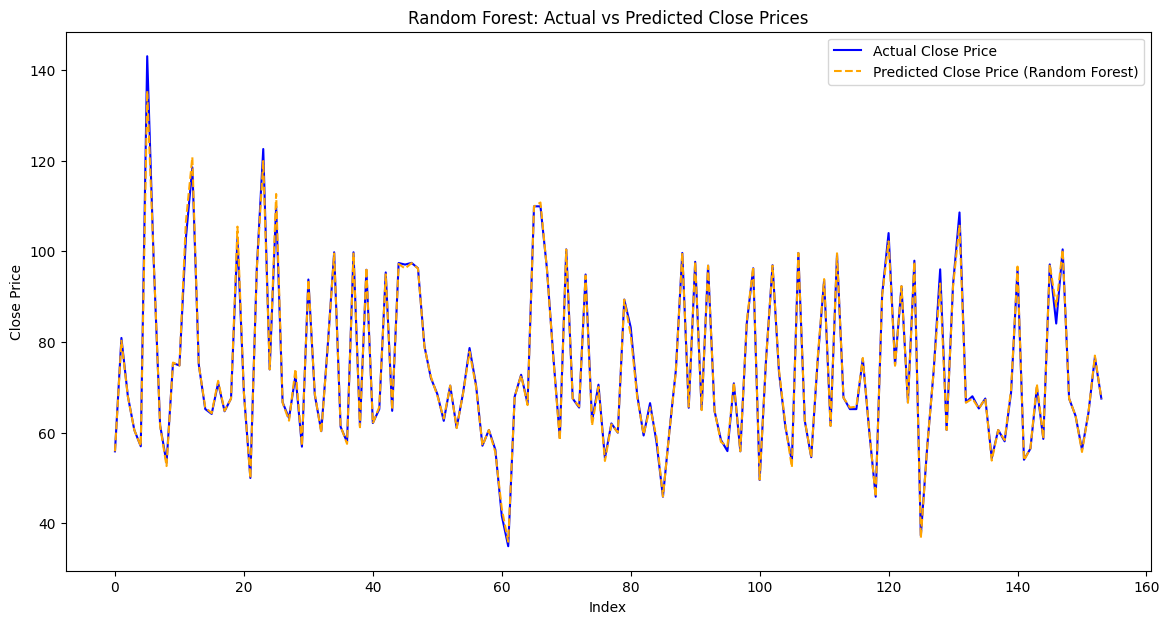

In [ ]:
# Flatten the predictions to ensure they are 1-dimensional
predictions_rf = np.ravel(predictions_rf)
predictions_lstm = np.ravel(predictions_lstm)

# Generate a numeric index for plotting
time_index_rf = range(len(Y_test_rf))
time_index_lstm = range(len(Y_test))

# Ensure predictions are Series with the same index
predictions_rf_series = pd.Series(predictions_rf, index=time_index_rf)
predictions_lstm_series = pd.Series(predictions_lstm, index=time_index_lstm)

# Plot actual vs predicted values for Random Forest
plt.figure(figsize=(14, 7))
plt.plot(time_index_rf, Y_test_rf, label='Actual Close Price', color='blue')
plt.plot(predictions_rf_series.index, predictions_rf_series, label='Predicted Close Price (Random Forest)', color='orange', linestyle='dashed')
plt.title('Random Forest: Actual vs Predicted Close Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()


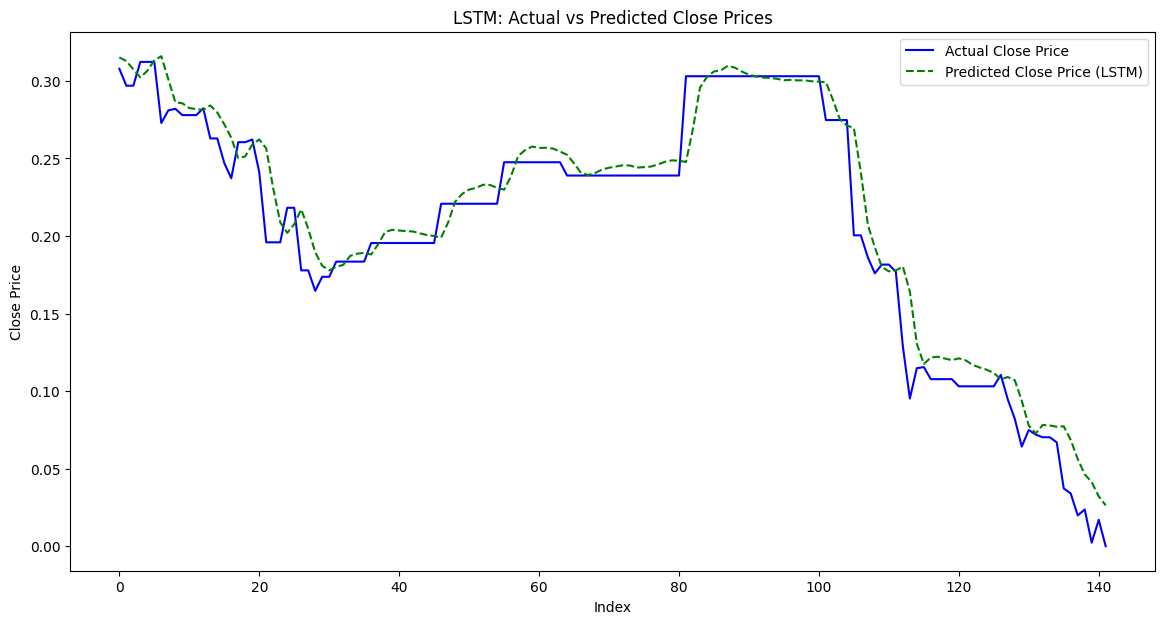

In [ ]:
# Plot actual vs predicted values for LSTM
plt.figure(figsize=(14, 7))
plt.plot(time_index_lstm, Y_test, label='Actual Close Price', color='blue')
plt.plot(predictions_lstm_series.index, predictions_lstm_series, label='Predicted Close Price (LSTM)', color='green', linestyle='dashed')
plt.title('LSTM: Actual vs Predicted Close Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

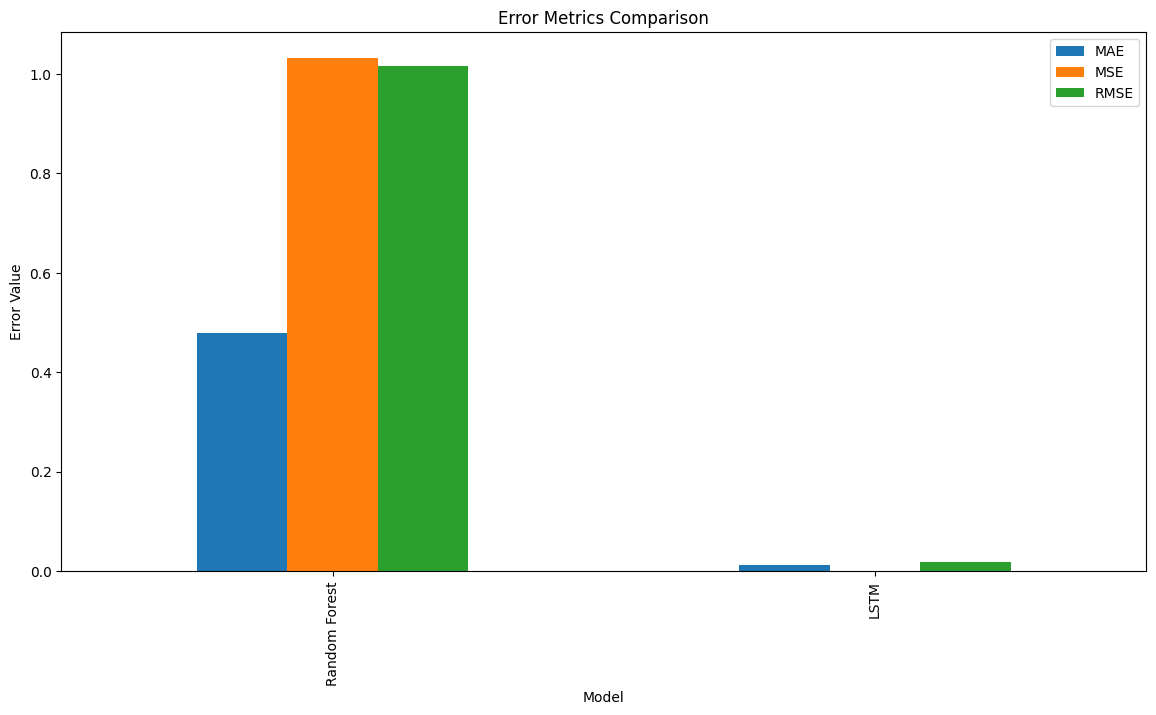

In [ ]:
# Bar Chart for Error Metrics
error_metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'MAE': [mae_rf, mae_lstm],
    'MSE': [mse_rf, mse_lstm],
    'RMSE': [rmse_rf, rmse_lstm]
})

error_metrics_df.set_index('Model').plot(kind='bar', figsize=(14, 7))
plt.title('Error Metrics Comparison')
plt.ylabel('Error Value')
plt.show()

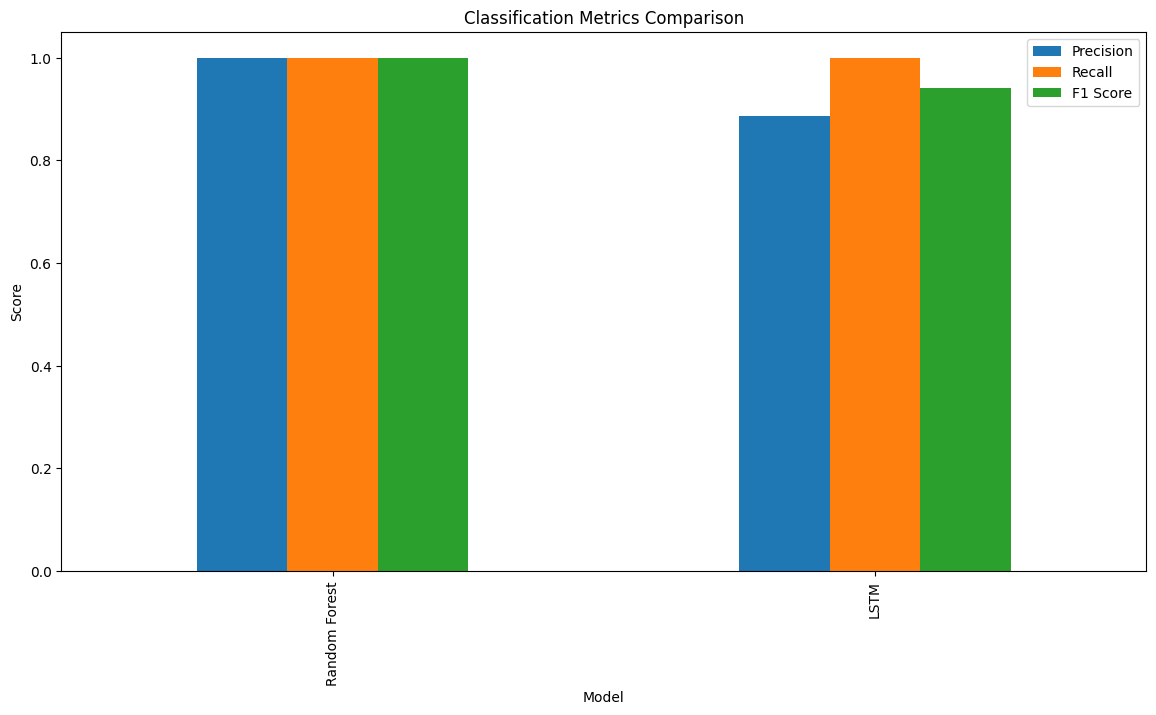

In [ ]:
# Bar Chart for Classification Metrics
classification_metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'Precision': [precision_rf, precision_lstm],
    'Recall': [recall_rf, recall_lstm],
    'F1 Score': [f1_rf, f1_lstm]
})

classification_metrics_df.set_index('Model').plot(kind='bar', figsize=(14, 7))
plt.title('Classification Metrics Comparison')
plt.ylabel('Score')
plt.show()

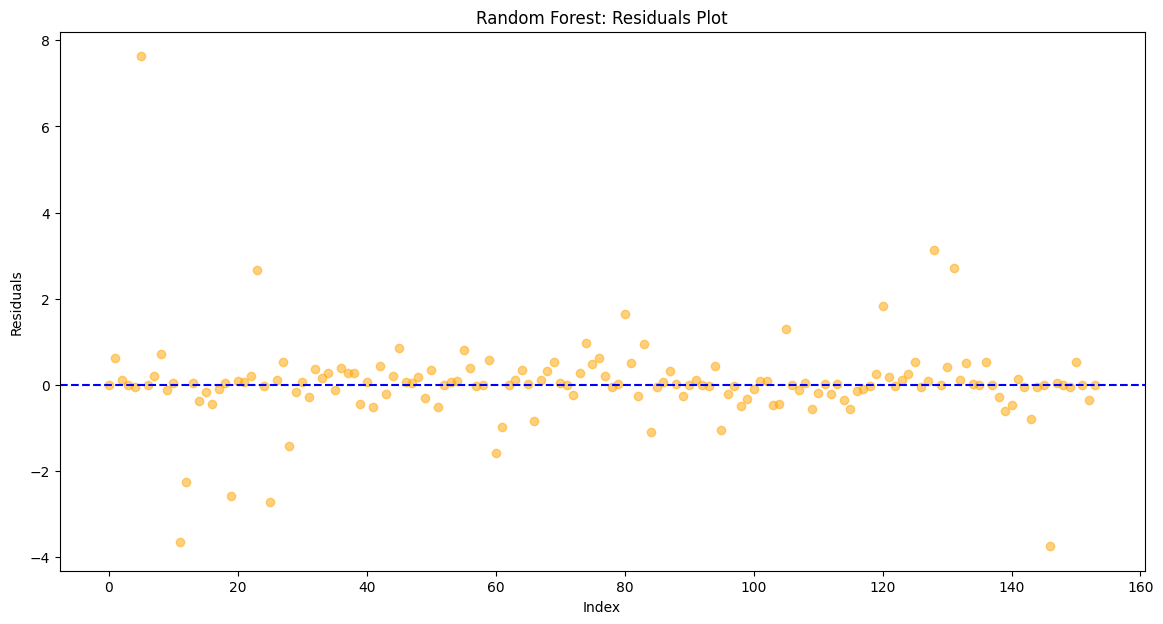

In [ ]:
# Residual Plot for Random Forest
residuals_rf = Y_test_rf - predictions_rf_series
plt.figure(figsize=(14, 7))
plt.scatter(time_index_rf, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='blue', linestyle='dashed')
plt.title('Random Forest: Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()


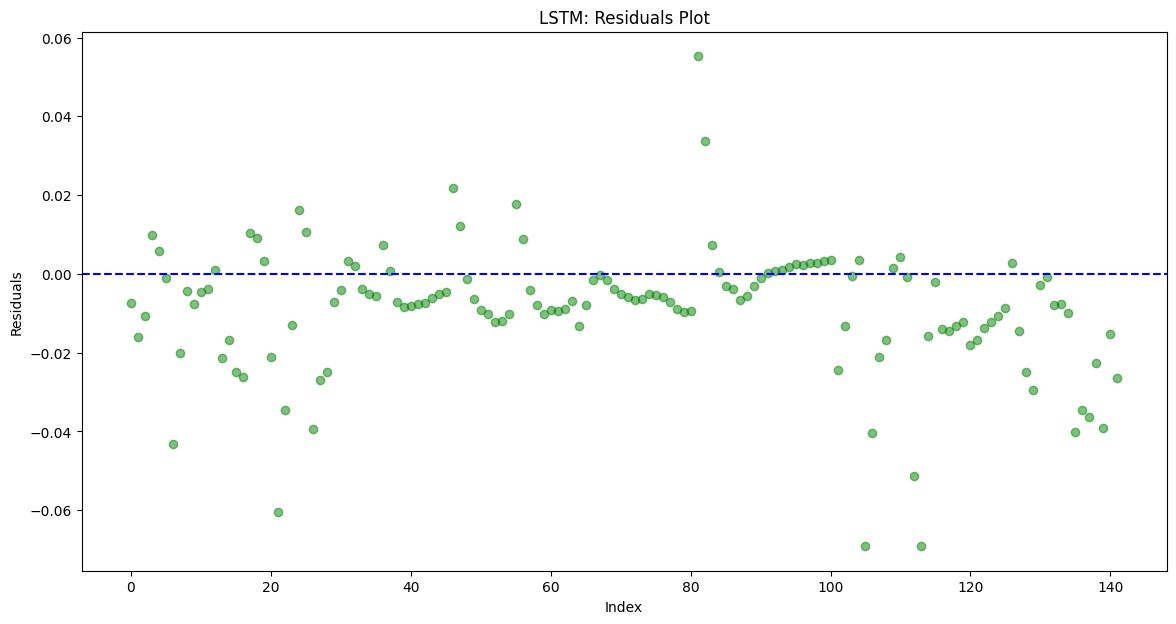

In [ ]:
# Residual Plot for LSTM
residuals_lstm = Y_test - predictions_lstm_series
plt.figure(figsize=(14, 7))
plt.scatter(time_index_lstm, residuals_lstm, alpha=0.5, color='green')
plt.axhline(y=0, color='blue', linestyle='dashed')
plt.title('LSTM: Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()


combined_data is not empty
Columns in combined_data:
Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')
Missing columns in combined_data: {'daily_return', 'volatility', 'sentiment_score', 'close'}
First few rows of combined_data with new timestamp column:
                  Date    Price     Open     High      Low  Vol. Change %  \
timestamp                                                                   
2024-06-16  06/16/2024  88.9896  88.9813  88.9921  88.9422   NaN   -0.66%   
2024-06-14  06/14/2024  89.5779  87.8755  90.2496  87.8529   NaN    1.94%   
2024-06-13  06/13/2024  87.8754  89.0214  91.7479  85.7496   NaN   -1.38%   
2024-06-11  06/11/2024  89.1025  88.5500  89.2890  88.5500   NaN    0.62%   
2024-06-10  06/10/2024  88.5500  89.3475  89.4350  88.5500   NaN   -0.89%   

            timestamp  
timestamp              
2024-06-16 2014-01-01  
2024-06-14 2014-01-02  
2024-06-13 2014-01-03  
2024-06-11 2014-01-04  
2024-06-10 2014-01-05  
Nec

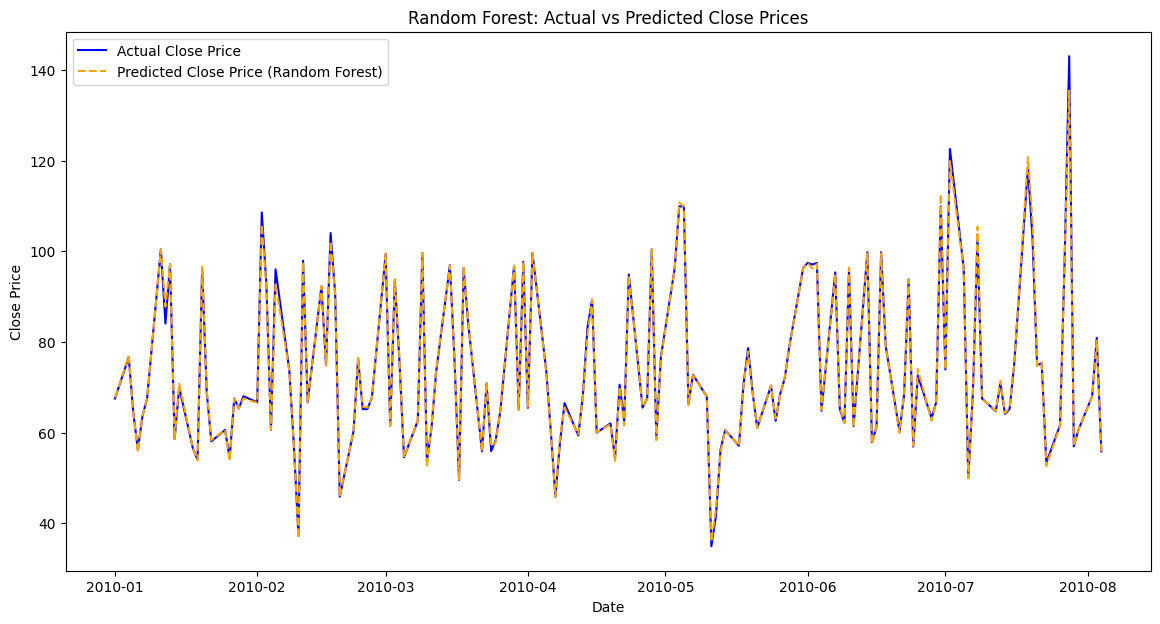

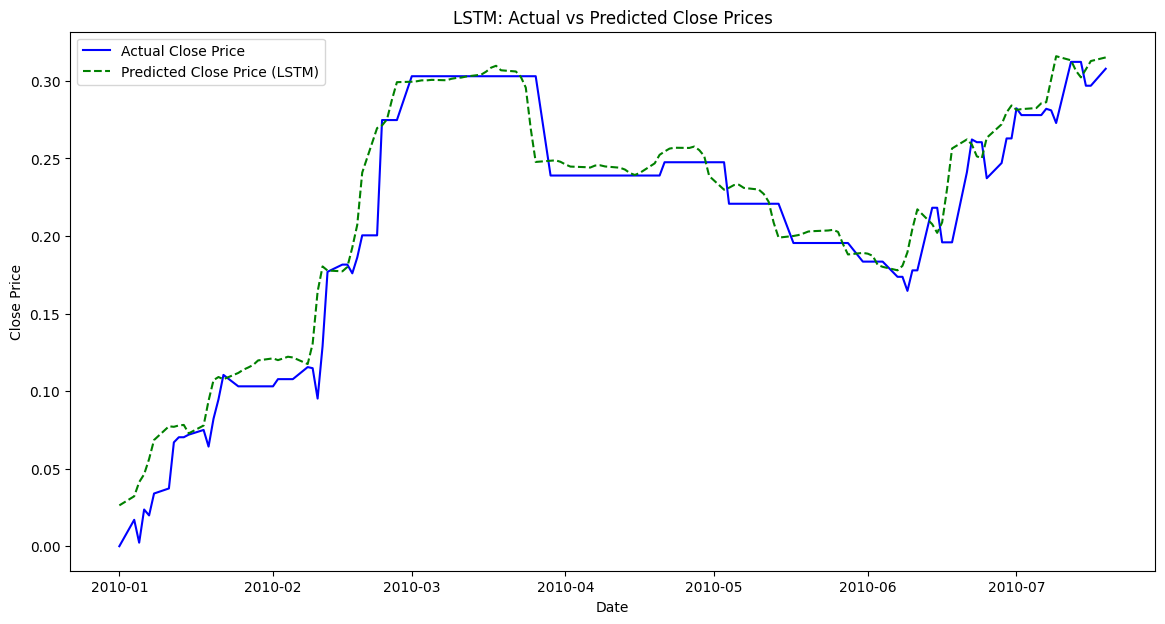

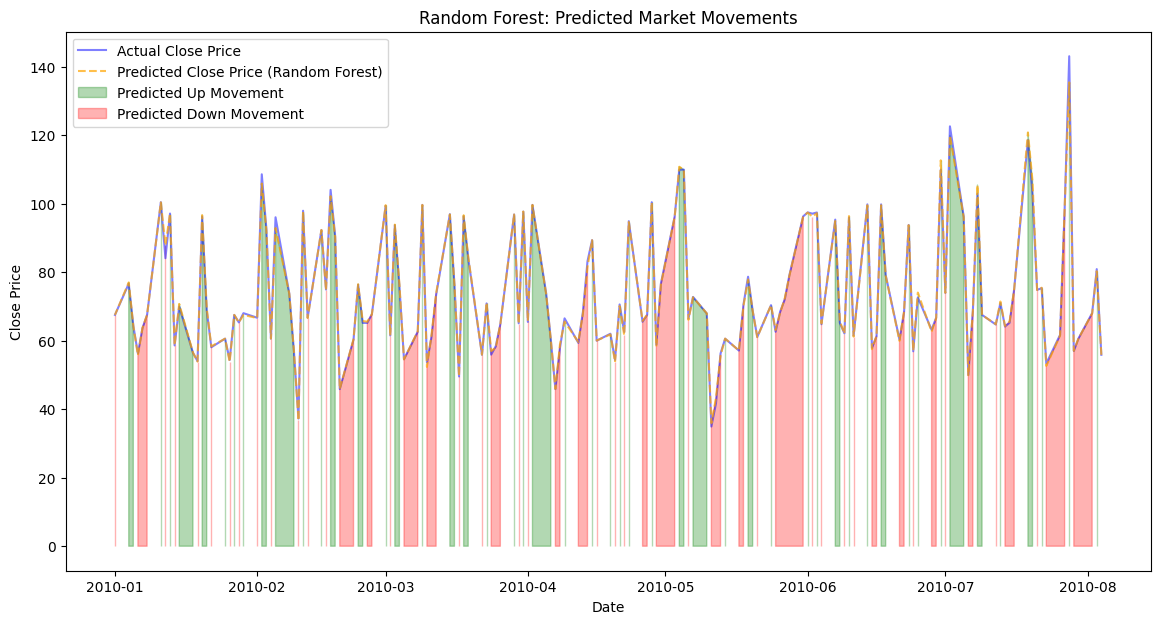

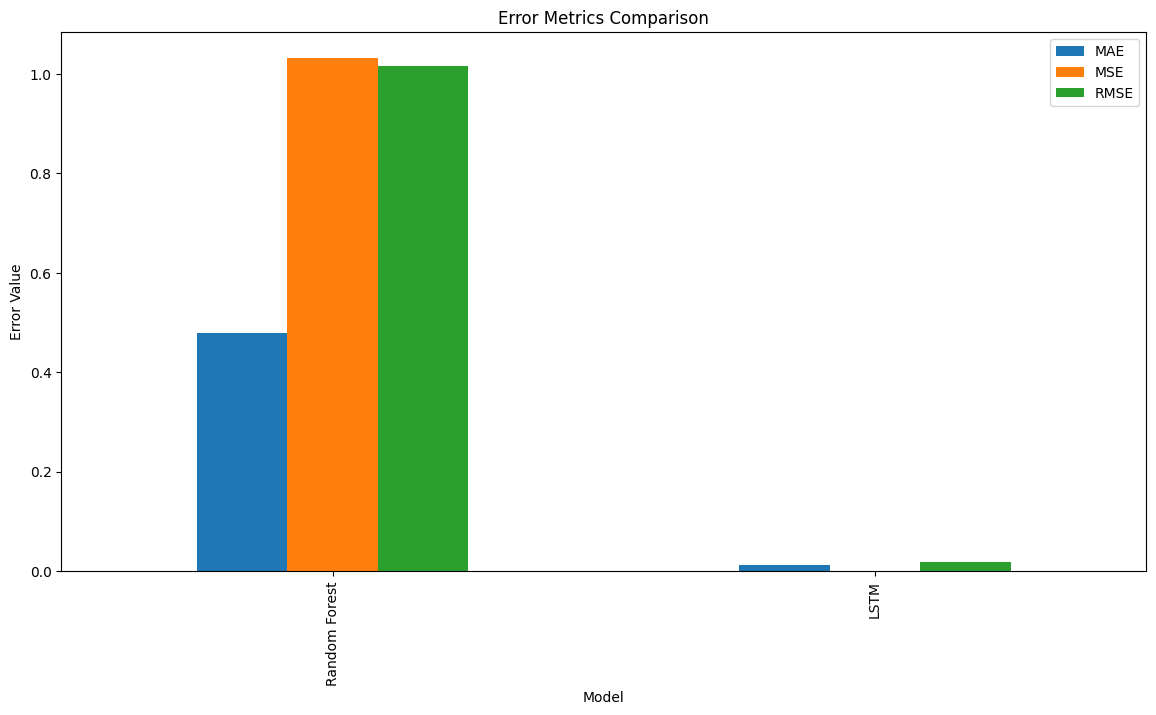

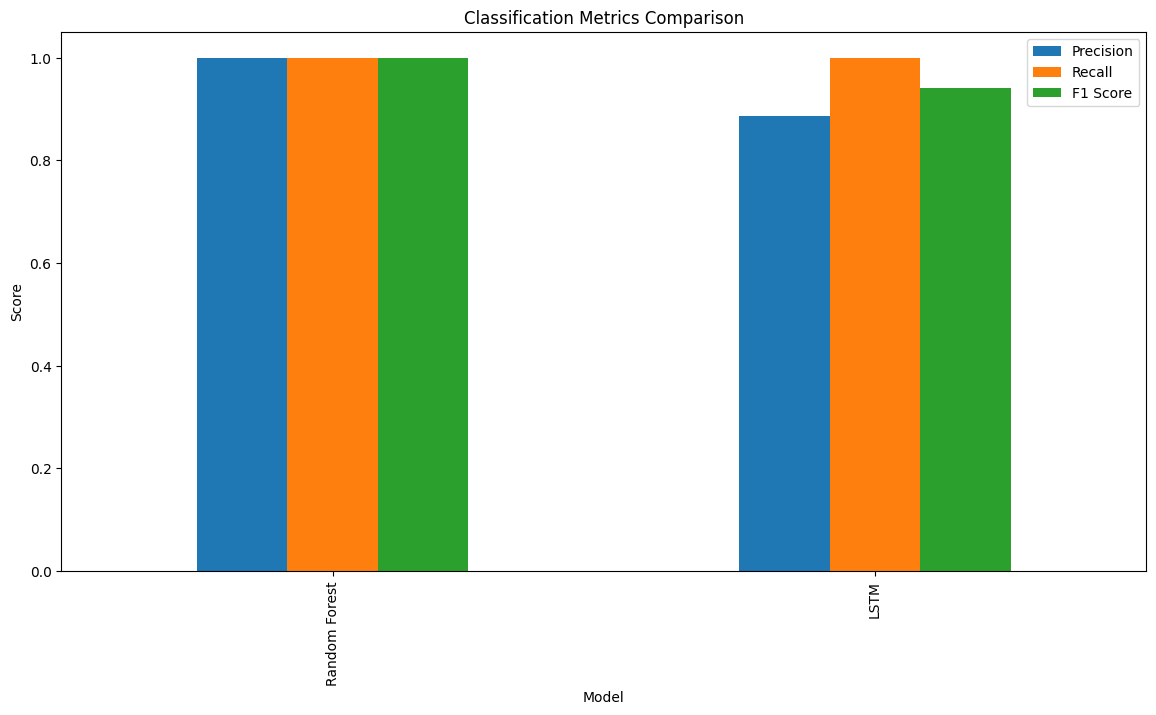

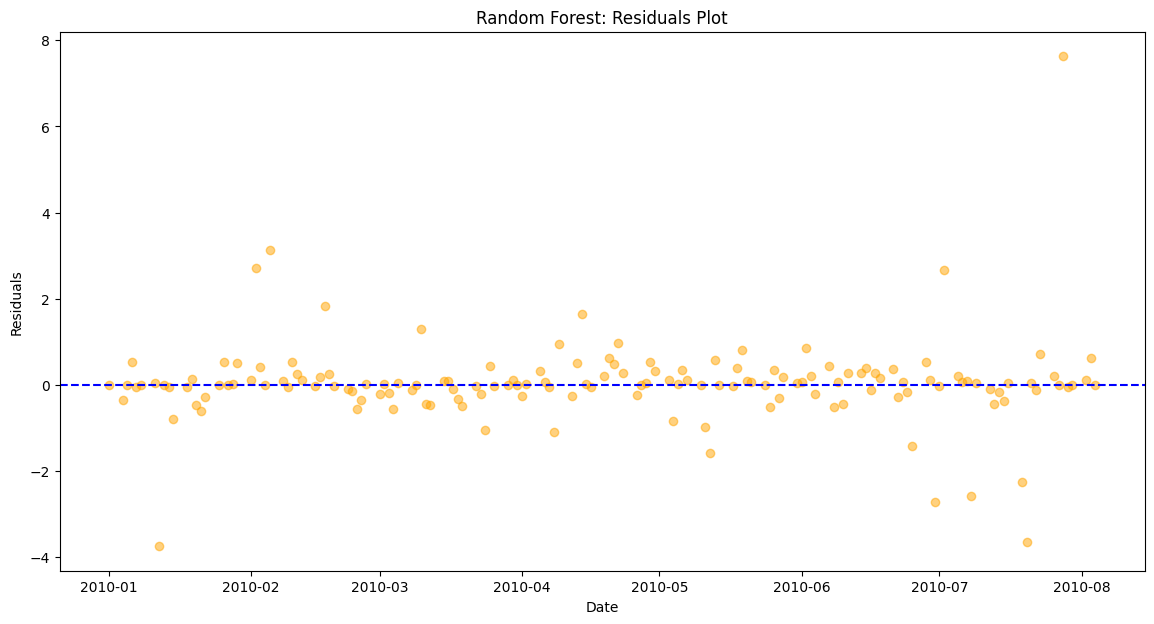

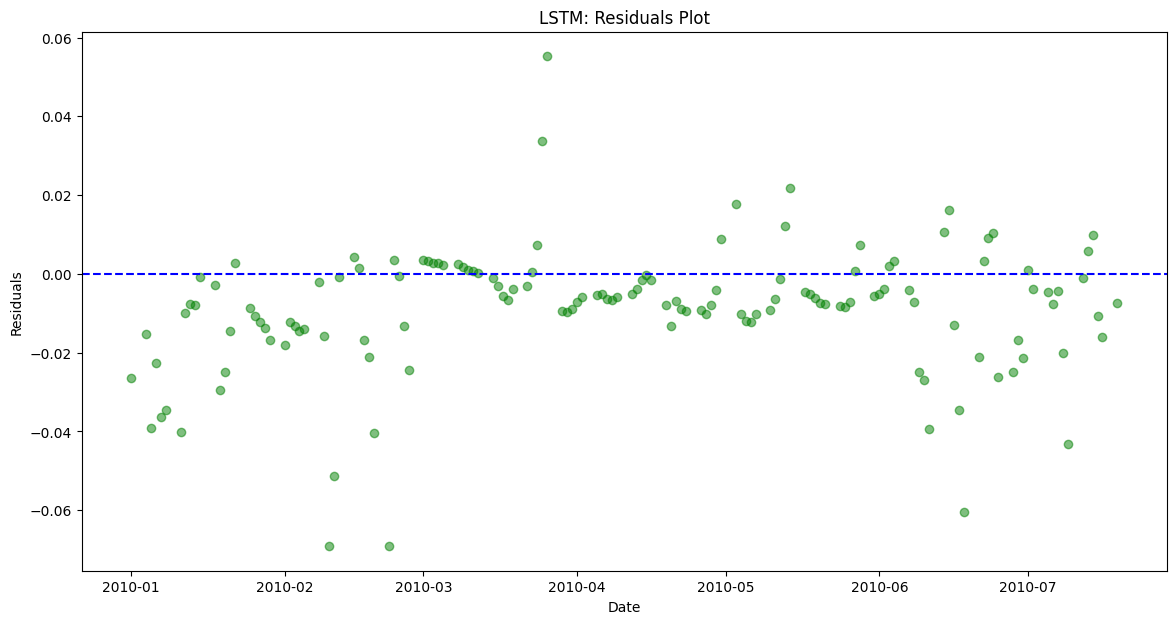

In [ ]:
if combined_data.empty:
    print("combined_data is empty")
else:
    print("combined_data is not empty")

print("Columns in combined_data:")
print(combined_data.columns)

# Check for the necessary columns
necessary_columns = ['close', 'daily_return', 'volatility', 'sentiment_score']
missing_columns = set(necessary_columns) - set(combined_data.columns)
if missing_columns:
    print(f"Missing columns in combined_data: {missing_columns}")

# Generate a date range from 2014 to 2024 with the same length as combined_data
date_range = pd.date_range(start='2014-01-01', periods=len(combined_data), freq='D')
combined_data['timestamp'] = date_range

# Verify the new 'timestamp' column
print("First few rows of combined_data with new timestamp column:")
print(combined_data.head())

# Calculate correlation matrix
if not missing_columns:
    corr_matrix = combined_data[necessary_columns].corr()

    # Enhanced Correlation Analysis and Visualization
    fig, ax = plt.subplots(3, 1, figsize=(14, 15))

    sns.lineplot(x=combined_data['timestamp'], y=combined_data['close'], ax=ax[0], label='Close Price')
    ax[0].set_title('Close Price Over Time')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Close Price')

    sns.lineplot(x=combined_data['timestamp'], y=combined_data['sentiment_score'], ax=ax[1], color='green', label='Sentiment Score')
    ax[1].set_title('Sentiment Score Over Time')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Sentiment Score')

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5, ax=ax[2])
    ax[2].set_title('Correlation Matrix')

    plt.tight_layout()
    plt.show()
else:
    print("Necessary columns are missing, cannot compute correlation matrix.")

# Predictions Visualization

time_index_rf = combined_data.index[-len(Y_test_rf):]
time_index_lstm = combined_data.index[-len(Y_test):]


predictions_rf = pd.Series(predictions_rf.flatten(), index=time_index_rf)
predictions_lstm = pd.Series(predictions_lstm.flatten(), index=time_index_lstm)

# Plot actual vs predicted values for Random Forest
plt.figure(figsize=(14, 7))
plt.plot(time_index_rf, Y_test_rf, label='Actual Close Price', color='blue')
plt.plot(predictions_rf.index, predictions_rf, label='Predicted Close Price (Random Forest)', color='orange', linestyle='dashed')
plt.title('Random Forest: Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot actual vs predicted values for LSTM
plt.figure(figsize=(14, 7))
plt.plot(time_index_lstm, Y_test, label='Actual Close Price', color='blue')
plt.plot(predictions_lstm.index, predictions_lstm, label='Predicted Close Price (LSTM)', color='green', linestyle='dashed')
plt.title('LSTM: Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Highlight Market Movements
plt.figure(figsize=(14, 7))
plt.plot(time_index_rf, Y_test_rf, label='Actual Close Price', color='blue', alpha=0.5)
plt.plot(predictions_rf.index, predictions_rf, label='Predicted Close Price (Random Forest)', color='orange', linestyle='dashed', alpha=0.7)

# Highlight predicted up and down movements
up_movements = predictions_rf > predictions_rf.shift(1)
down_movements = predictions_rf < predictions_rf.shift(1)
plt.fill_between(predictions_rf.index, predictions_rf, where=up_movements, color='green', alpha=0.3, label='Predicted Up Movement')
plt.fill_between(predictions_rf.index, predictions_rf, where=down_movements, color='red', alpha=0.3, label='Predicted Down Movement')

plt.title('Random Forest: Predicted Market Movements')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Bar Chart for Error Metrics
error_metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'MAE': [mae_rf, mae_lstm],
    'MSE': [mse_rf, mse_lstm],
    'RMSE': [rmse_rf, rmse_lstm]
})

error_metrics_df.set_index('Model').plot(kind='bar', figsize=(14, 7))
plt.title('Error Metrics Comparison')
plt.ylabel('Error Value')
plt.show()

# Bar Chart for Classification Metrics
classification_metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'Precision': [precision_rf, precision_lstm],
    'Recall': [recall_rf, recall_lstm],
    'F1 Score': [f1_rf, f1_lstm]
})

classification_metrics_df.set_index('Model').plot(kind='bar', figsize=(14, 7))
plt.title('Classification Metrics Comparison')
plt.ylabel('Score')
plt.show()

# Residual Plot for Random Forest
residuals_rf = Y_test_rf - predictions_rf
plt.figure(figsize=(14, 7))
plt.scatter(time_index_rf, residuals_rf, alpha=0.5, color='orange')
plt.axhline(y=0, color='blue', linestyle='dashed')
plt.title('Random Forest: Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Residual Plot for LSTM
residuals_lstm = Y_test - predictions_lstm
plt.figure(figsize=(14, 7))
plt.scatter(time_index_lstm, residuals_lstm, alpha=0.5, color='green')
plt.axhline(y=0, color='blue', linestyle='dashed')
plt.title('LSTM: Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()


# Enhanced Analysis and Insights

# 1. Contribution of Open-Source Forex Data to Market Dynamics Understanding
# Analyze how sentiment trends align with major market movements and events.

# 2. Key Insights from Analysis of Open-Source Data and Sentiment Analysis
# Identify key periods where sentiment scores show significant correlation with market movements.

# 3. Improvement of Forecasting Capabilities with Alternative Data Sources
# Compare model performance metrics before and after including sentiment scores.

# 4. Correlation of Sentiment Analysis Findings with Price Movements
# Detailed correlation analysis and visualization for sentiment scores and price movements.

# 5. Integration of Alternative Data into Algorithmic Trading Strategies
# Simulate trading strategies using sentiment scores and evaluate performance.